# <div style="text-align: right"> Chapter __19__</div>

# __Model building__

In [2]:
# config
repr_html.tbl_df <- function(obj, ..., rows = 6) repr:::repr_html.data.frame(obj, ..., rows = rows)
options(dplyr.summarise.inform = FALSE)

## __Introduction__

In the previous chapter you learned how linear models worked, and
learned some basic tools for understanding what a model is telling
you about your data. The previous chapter focused on simulated
datasets to help you learn about how models work. This chapter will
focus on real data, showing you how you can progressively build up
a model to aid your understanding of the data.

We will take advantage of the fact that you can think about a model
partitioning your data into patterns and residuals. We’ll find pat‐
terns with visualization, then make them concrete and precise with a
model. We’ll then repeat the process, but replace the old response
variable with the residuals from the model. The goal is to transition
from implicit knowledge in the data and your head to explicit
knowledge in a quantitative model. This makes it easier to apply to
new domains, and easier for others to use.

For very large and complex datasets this will be a lot of work. There
are certainly alternative approaches—a more machine learning
approach is simply to focus on the predictive ability of the model.
These approaches tend to produce black boxes: the model does a
really good job at generating predictions, but you don’t know why.
This is a totally reasonable approach, but it does make it hard to
apply your real-world knowledge to the model. That, in turn, makes
it difficult to assess whether or not the model will continue to work
in the long term, as fundamentals change. For most real models, I’d
expect you to use some combination of this approach and a more
classic automated approach.
It’s a challenge to know when to stop. You need to figure out when
your model is good enough, and when additional investment is
unlikely to pay off. I particularly like this quote from reddit user
Broseidon241:

A long time ago in art class, my teacher told me “An artist needs to
know when a piece is done. You can’t tweak something into perfec‐
tion—wrap it up. If you don’t like it, do it over again. Otherwise
begin something new.” Later in life, I heard “A poor seamstress
makes many mistakes. A good seamstress works hard to correct
those mistakes. A great seamstress isn’t afraid to throw out the gar‐
ment and start over.”

-Broseidon241

In [1]:
library(tidyverse)
library(lubridate)
library(modelr)
options(na.action = na.warn)

library(nycflights13)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




## Why Are Low-Quality Diamonds More Expensive?

In previous chapters we’ve seen a surprising relationship between
the quality of diamonds and their price: low-quality diamonds (poor
cuts, bad colors, and inferior clarity) have higher prices:

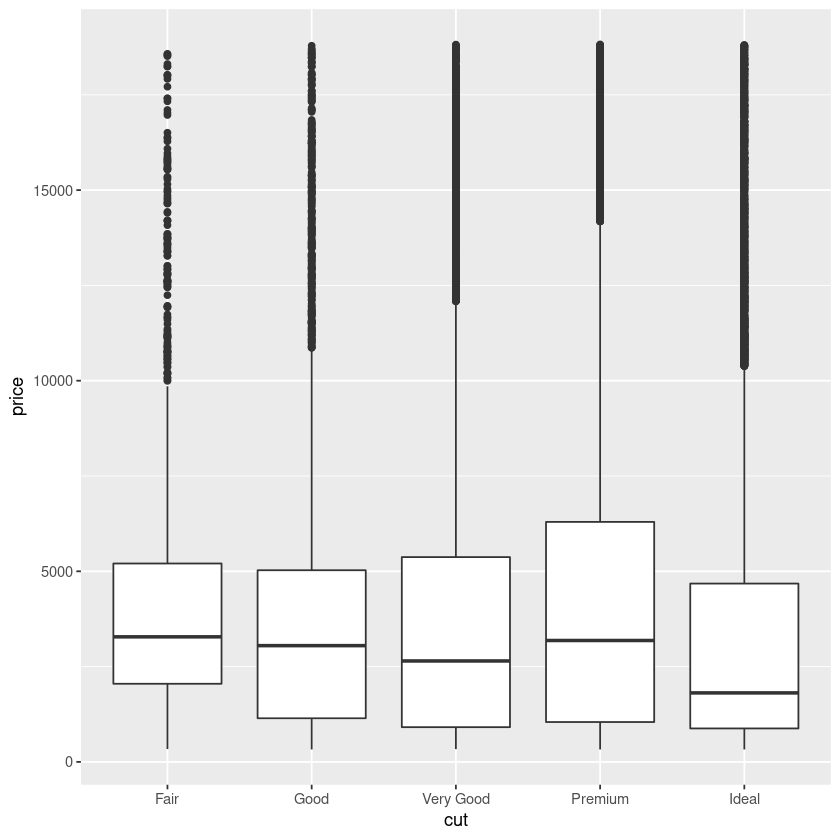

In [2]:
ggplot(diamonds, aes(cut, price)) +
    geom_boxplot()

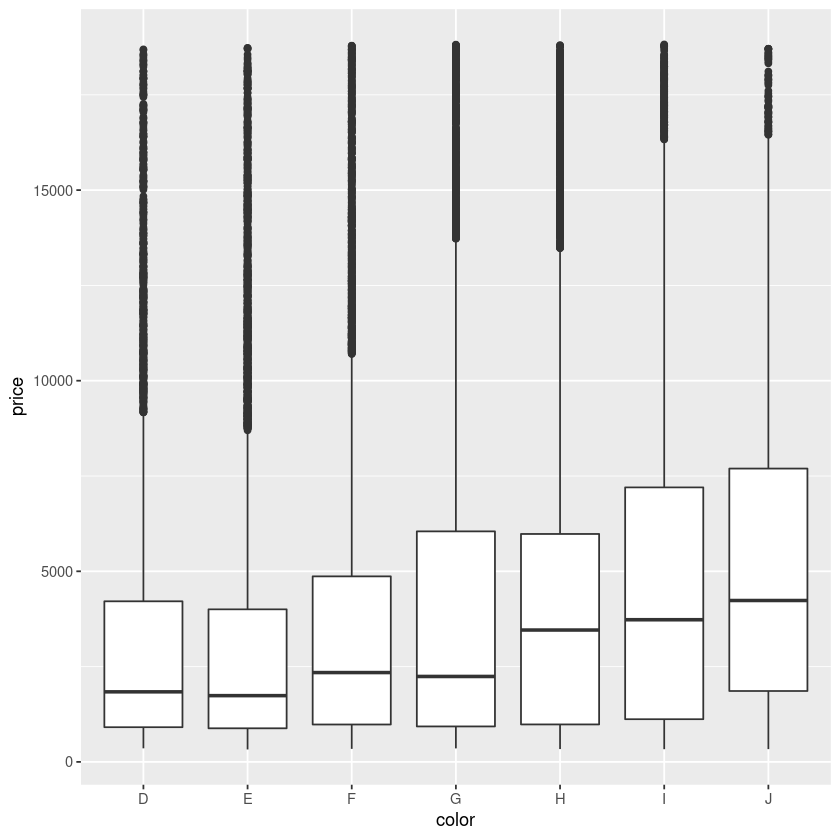

In [3]:
ggplot(diamonds, aes(color, price)) +
    geom_boxplot()

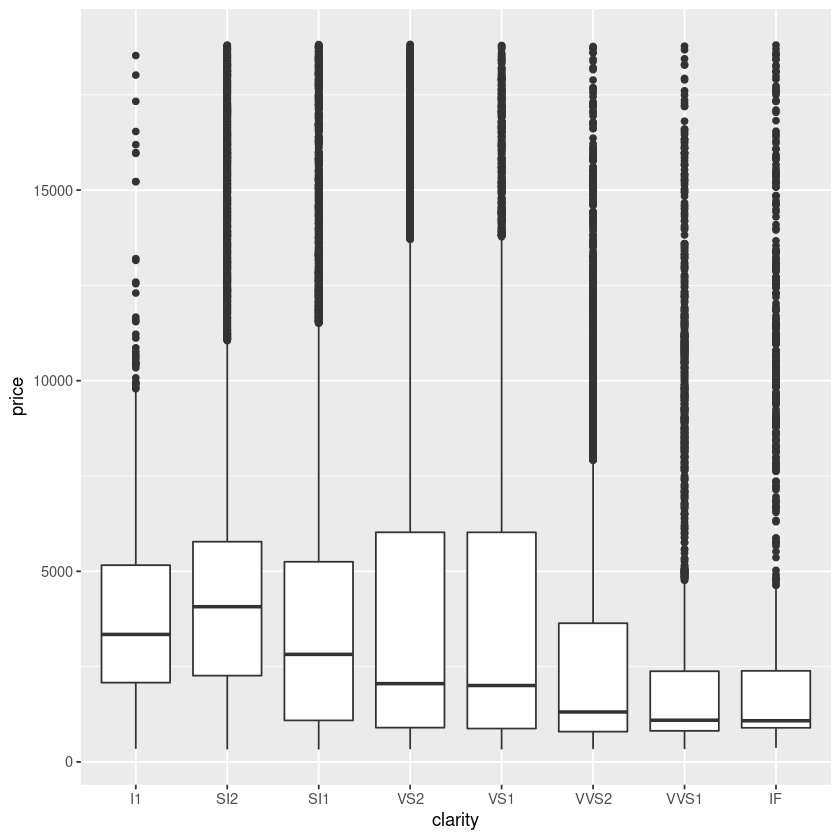

In [4]:
ggplot(diamonds, aes(clarity, price)) +
    geom_boxplot()

Note that the worst diamond color is J (slightly yellow), and the
worst clarity is I1 (inclusions visible to the naked eye).

### Price and Carat

It looks like lower-quality diamonds have higher prices because
there is an important confounding variable: the weight ( carat ) of
the diamond. The weight of the diamond is the single most important factor for determining the price of the diamond, and lower quality diamonds tend to be larger:

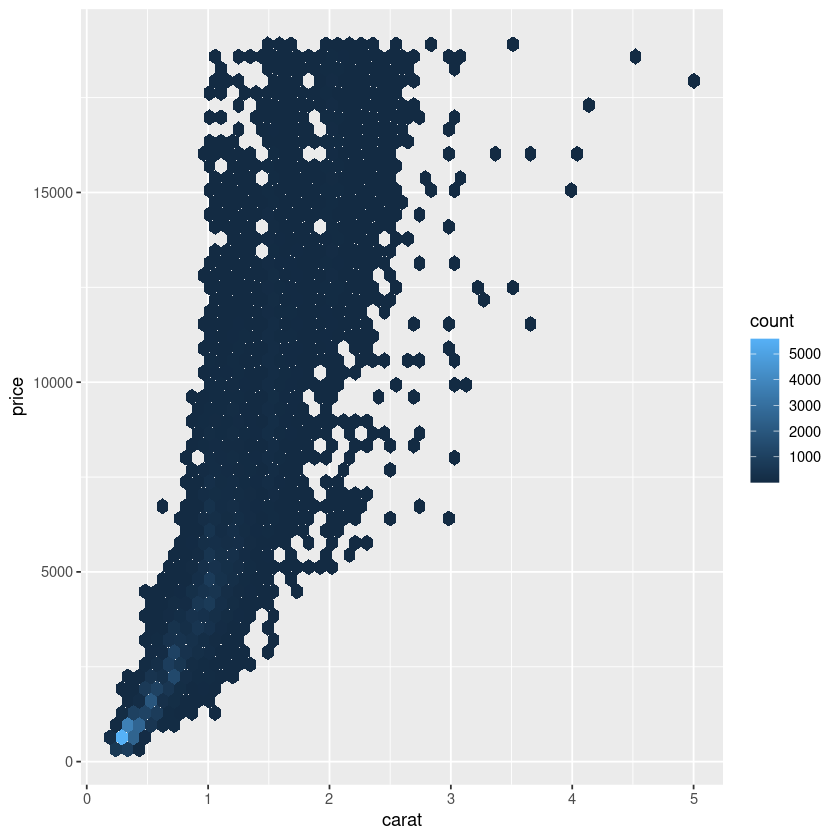

In [7]:
ggplot(diamonds, aes(carat, price)) +
    geom_hex(bins = 50)

We can make it easier to see how the other attributes of a diamond
affect its relative price by fitting a model to separate out the effect
of carat . But first, let’s make a couple of tweaks to the diamonds
dataset to make it easier to work with:

1. Focus on diamonds smaller than 2.5 carats (99.7% of the data).
2. Log-transform the carat and price variables:

In [8]:
diamonds2 <- diamonds %>%
    filter(carat <= 2.5) %>%
    mutate(lprice = log2(price), lcarat = log2(carat))

Together, these changes make it easier to see the relationship
between carat and price :

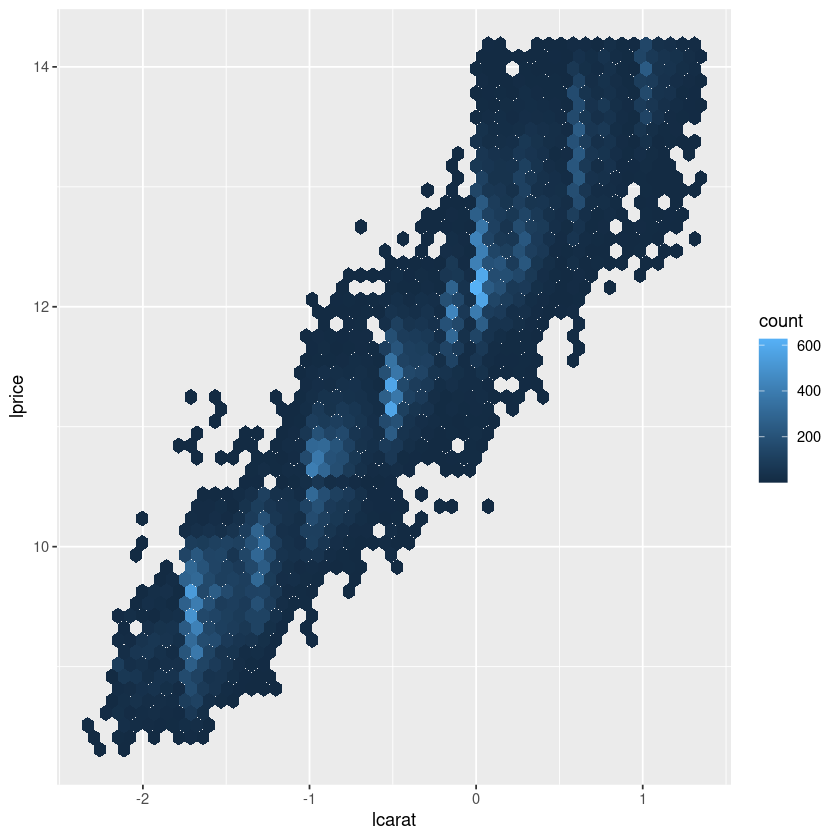

In [9]:
ggplot(diamonds2, aes(lcarat, lprice)) +
    geom_hex(bins = 50)

The log transformation is particularly useful here because it makes
the pattern linear, and linear patterns are the easiest to work with.
Let’s take the next step and remove that strong linear pattern. We
first make the pattern explicit by fitting a model:

In [10]:
mod_diamond <- lm(lprice ~ lcarat, data = diamonds2)

Then we look at what the model tells us about the data. Note that I
back-transform the predictions, undoing the log transformation, so
I can overlay the predictions on the raw data:

In [11]:
grid <- diamonds2 %>%
    data_grid(carat = seq_range(carat, 20)) %>%
    mutate(lcarat = log2(carat)) %>%
    add_predictions(mod_diamond, 'lprice') %>%
    mutate(price = 2 ^ lprice)

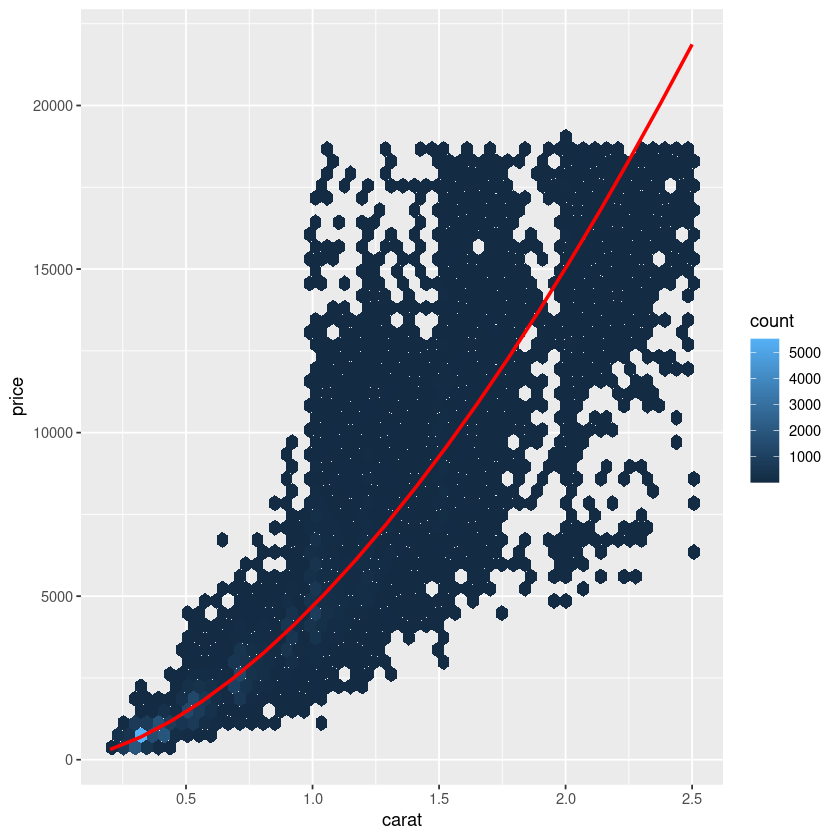

In [15]:
ggplot() +
    geom_hex(data = diamonds2,
             mapping = aes(carat, price),
             bins = 50) +
    geom_line(data = grid,
              mapping = aes(carat, price),
              color = 'red',
              size = 1)

That tells us something interesting about our data. If we believe our
model, then the large diamonds are much cheaper than expected.
This is probably because no diamond in this dataset costs more than
$19,000.

Now we can look at the residuals, which verifies that we’ve successfully removed the strong linear pattern:

In [16]:
diamonds2 <- diamonds2 %>%
    add_residuals(mod_diamond, 'lresid')

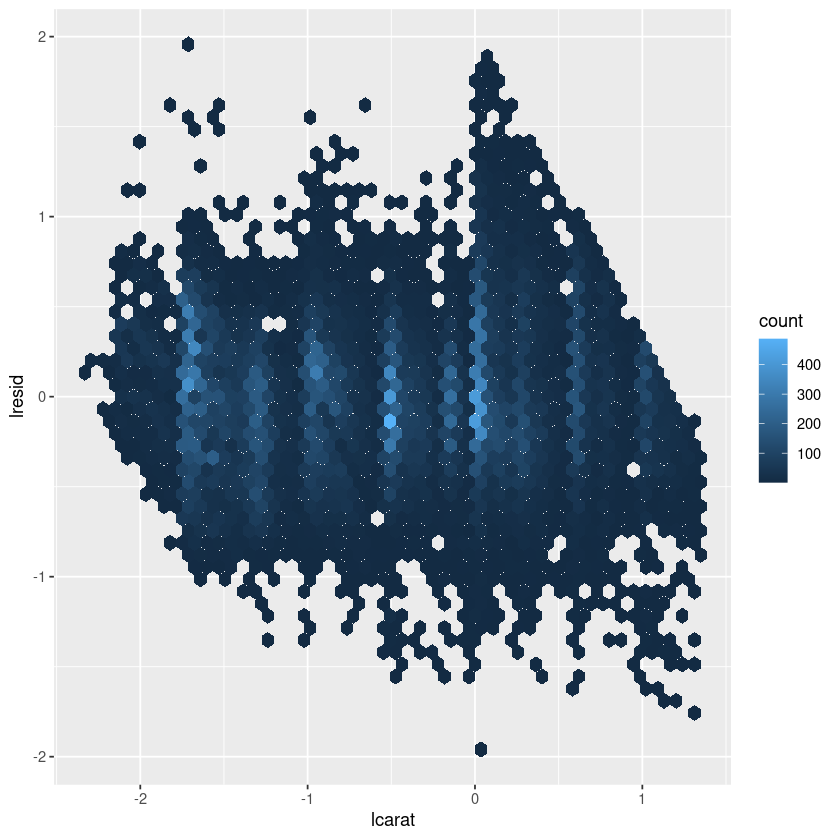

In [17]:
ggplot(diamonds2, aes(lcarat, lresid)) +
    geom_hex(bins = 50)

Importantly, we can now redo our motivating plots using those
residuals instead of price :

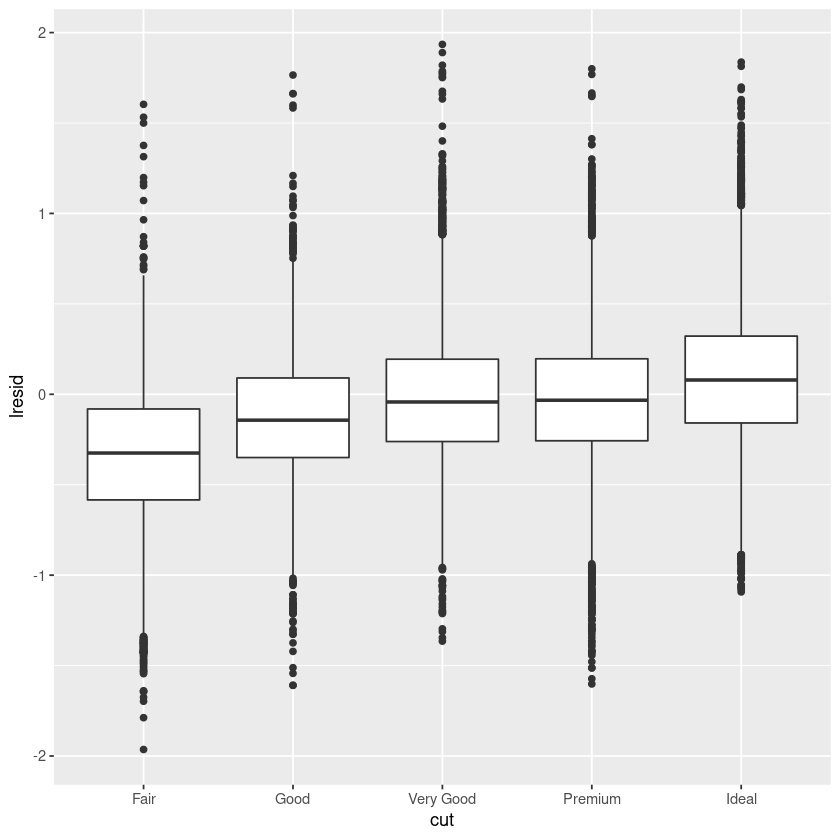

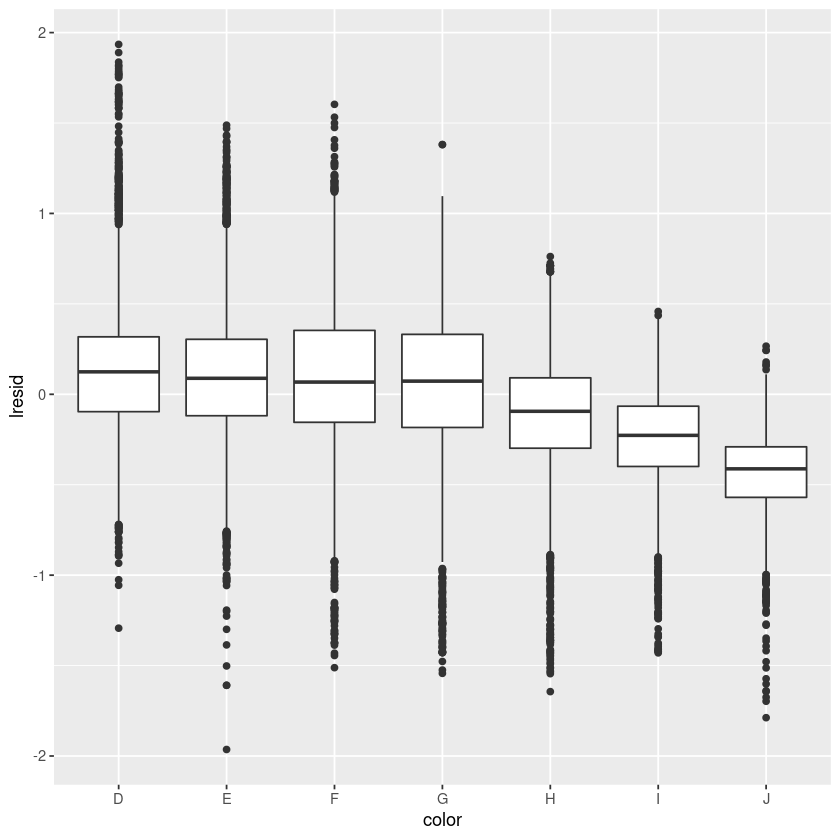

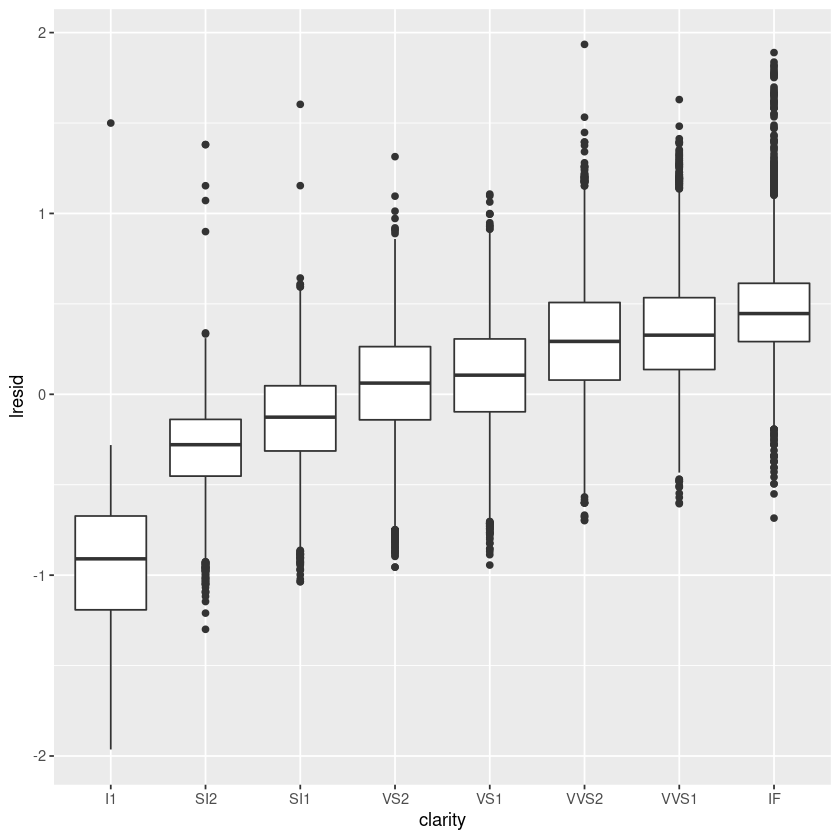

In [19]:
ggplot(diamonds2, aes(cut, lresid)) + geom_boxplot()
ggplot(diamonds2, aes(color, lresid)) + geom_boxplot()
ggplot(diamonds2, aes(clarity, lresid)) + geom_boxplot()

Now we see the relationship we expect: as the quality of the dia‐
mond increases, so to does its relative price. To interpret the y-axis,
we need to think about what the residuals are telling us, and what
scale they are on. A residual of –1 indicates that lprice was 1 unit
lower than a prediction based solely on its weight. 2 -1 is 1/2, so
points with a value of –1 are half the expected price, and residuals
with value 1 are twice the predicted price.

## A More Complicated Model

If we wanted to, we could continue to build up our model, moving
the effects we’ve observed into the model to make them explicit. For
example, we could include `color` , `cut` , and `clarity` into the model
so that we also make explicit the effect of these three categorical
variables:

In [20]:
mod_diamond2 <- lm(
    lprice ~ lcarat + color + cut + clarity,
    data = diamonds2
)

This model now includes four predictors, so it’s getting harder to
visualize. Fortunately, they’re currently all independent, which
means that we can plot them individually in four plots. To make the
process a little easier, we’re going to use the `.model` argument to
`data_grid` :

In [24]:
grid <- diamonds2 %>%
    data_grid(cut, .model = mod_diamond2) %>%
    add_predictions(mod_diamond2)

In [25]:
grid

cut,lcarat,color,clarity,pred
<ord>,<dbl>,<chr>,<chr>,<dbl>
Fair,-0.5145732,G,VS2,11.20557
Good,-0.5145732,G,VS2,11.32050
Very Good,-0.5145732,G,VS2,11.37396
Premium,-0.5145732,G,VS2,11.40627
Ideal,-0.5145732,G,VS2,11.43759


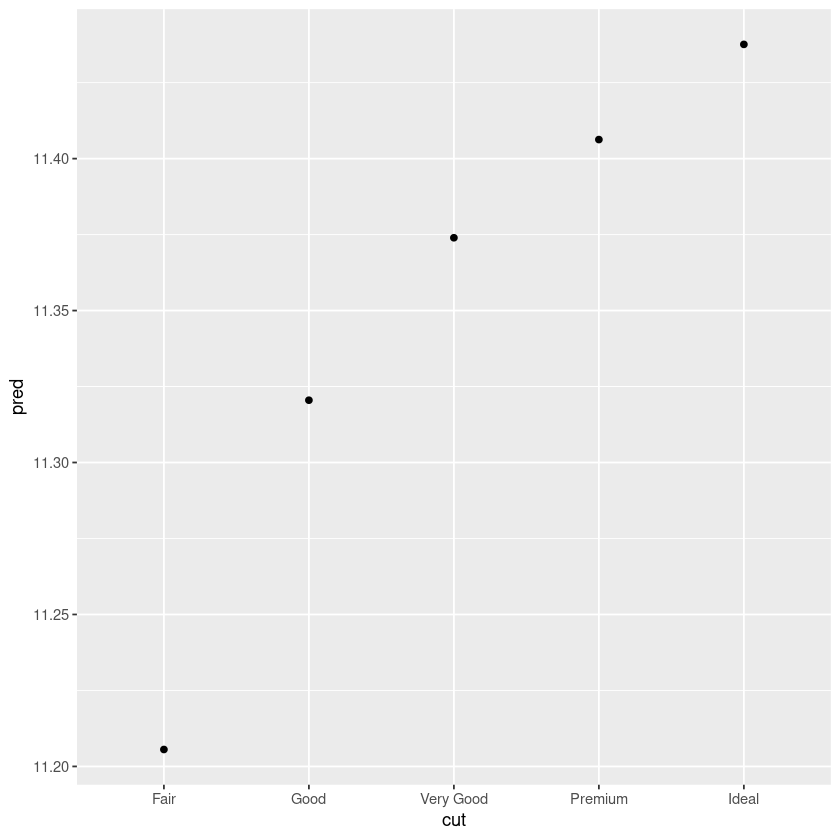

In [26]:
ggplot(grid, aes(cut, pred)) +
    geom_point()

If the model needs variables that you haven’t explicitly supplied,
`data_grid()` will automatically fill them in with the “typical” value.
For continuous variables, it uses the median, and for categorical
variables, it uses the most common value (or values, if there’s a tie):

In [27]:
diamonds2 <- diamonds2 %>%
    add_residuals(mod_diamond2, 'lresid2')

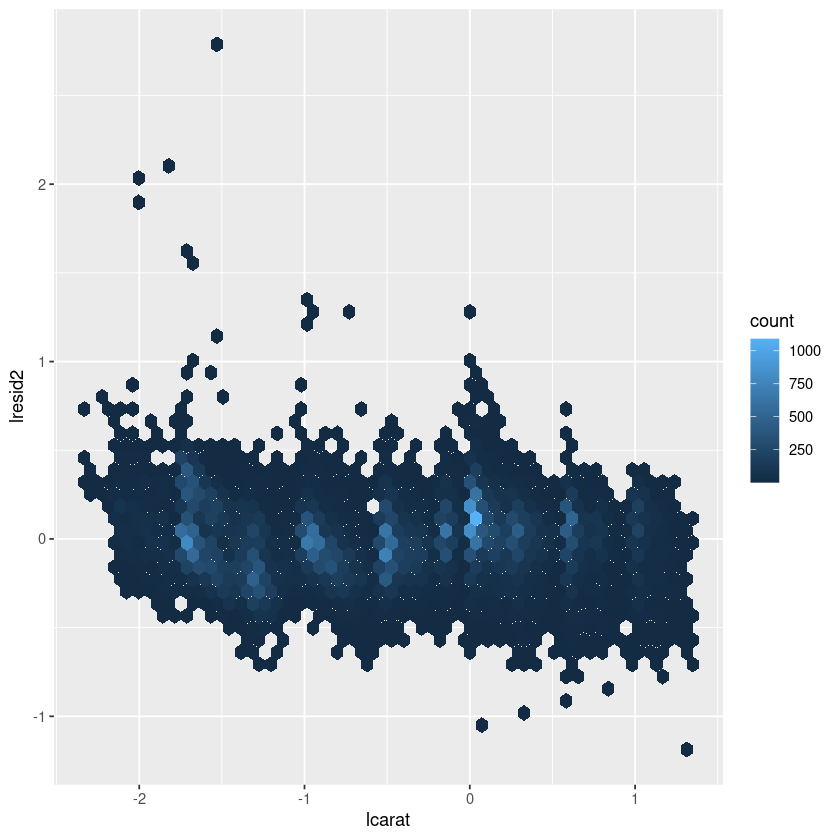

In [28]:
ggplot(diamonds2, aes(lcarat, lresid2)) +
    geom_hex(bins = 50)

This plot indicates that there are some diamonds with quite large
residuals—remember a residual of 2 indicates that the diamond is 4x
the price that we expected. It’s often useful to look at unusual values
individually:

In [30]:
diamonds2 %>%
    filter(abs(lresid2) > 1) %>%
    add_predictions(mod_diamond2) %>%
    mutate(pred = round(2 ^ pred)) %>%
    select(price, pred, carat:table, x:z) %>%
    arrange(price)

price,pred,carat,cut,color,clarity,depth,table,x,y,z
<int>,<dbl>,<dbl>,<ord>,<ord>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1013,264,0.25,Fair,F,SI2,54.4,64,4.30,4.23,2.32
1186,284,0.25,Premium,G,SI2,59.0,60,5.33,5.28,3.12
1186,284,0.25,Premium,G,SI2,58.8,60,5.33,5.28,3.12
1262,2644,1.03,Fair,E,I1,78.2,54,5.72,5.59,4.42
1415,639,0.35,Fair,G,VS2,65.9,54,5.57,5.53,3.66
1415,639,0.35,Fair,G,VS2,65.9,54,5.57,5.53,3.66
1715,576,0.32,Fair,F,VS2,59.6,60,4.42,4.34,2.61
1776,412,0.29,Fair,F,SI1,55.8,60,4.48,4.41,2.48
2160,314,0.34,Fair,F,I1,55.8,62,4.72,4.60,2.60


Nothing really jumps out at me here, but it’s probably worth spending time considering if this indicates a problem with our model, or if
there are errors in the data. If there are mistakes in the data, this
could be an opportunity to buy diamonds that have been priced low
incorrectly.

### __Excercises__

1. __In the plot of lcarat versus lprice , there are some bright verti‐
cal strips. What do they represent?__

The distribution of diamonds has more diamonds at round or otherwise human-friendly numbers (fractions).

2. If `log(price) = a_0 + a_1 * log(carat)` , what does that say
about the relationship between `price` and `carat` ?

In [31]:
mod_log <- lm(log2(price) ~ log2(carat), data = diamonds)
mod_log


Call:
lm(formula = log2(price) ~ log2(carat), data = diamonds)

Coefficients:
(Intercept)  log2(carat)  
     12.189        1.676  


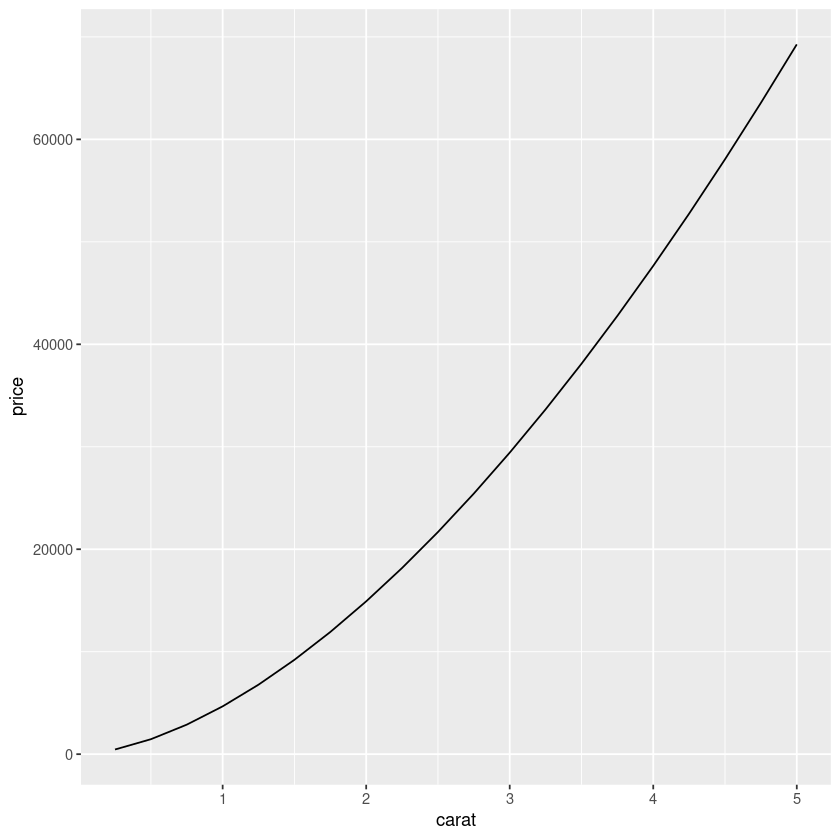

In [32]:
tibble(carat = seq(0.25, 5, by = 0.25)) %>%
  add_predictions(mod_log) %>%
  ggplot(aes(x = carat, y = 2^pred)) +
  geom_line() +
  labs(x = "carat", y = "price")

The plot shows that the estimated relationship between carat and price is not linear. The exact relationship in this model is if `x` increases `r` times, then `y` increases $r^{a_1}$ times. For example, a two times increase in carat is associated with the following increase in price:

In [33]:
2^coef(mod_log)[2]

log2(carat) 
   3.195002

Let’s confirm this relationship by checking it for a few values of the carat variable. Let’s increase carat from 1 to 2.

In [34]:
2^(predict(mod_log, newdata = tibble(carat = 2)) -
  predict(mod_log, newdata = tibble(carat = 1)))

1 
3.195002

Note that, since `predict()` predicts `log2(carat)` rather than `carat`, the prediction is exponentiated by 2. Now let’s increase `carat` from 4 to 2.

In [35]:
2^(predict(mod_log, newdata = tibble(carat = 4)) -
  predict(mod_log, newdata = tibble(carat = 2)))

1 
3.195002

Finally, let’s increase carat from 0.5 to 1.

In [37]:
2^(predict(mod_log, newdata = tibble(carat = 1)) -
  predict(mod_log, newdata = tibble(carat = 0.5)))

1 
3.195002

4. __Does the final model, mod_diamonds2 , do a good job of predict‐
ing diamond prices? Would you trust it to tell you how much to
spend if you were buying a diamond?__

Plotting the residuals of the model shows that there are some large outliers for small carat sizes. The largest of these residuals are a little over two, which means that the true value was four times lower; 
Most of the mass of the residuals is between -0.5 and 0.5, which corresponds to about ±40. There seems to be a slight downward bias in the residuals as carat size increases.

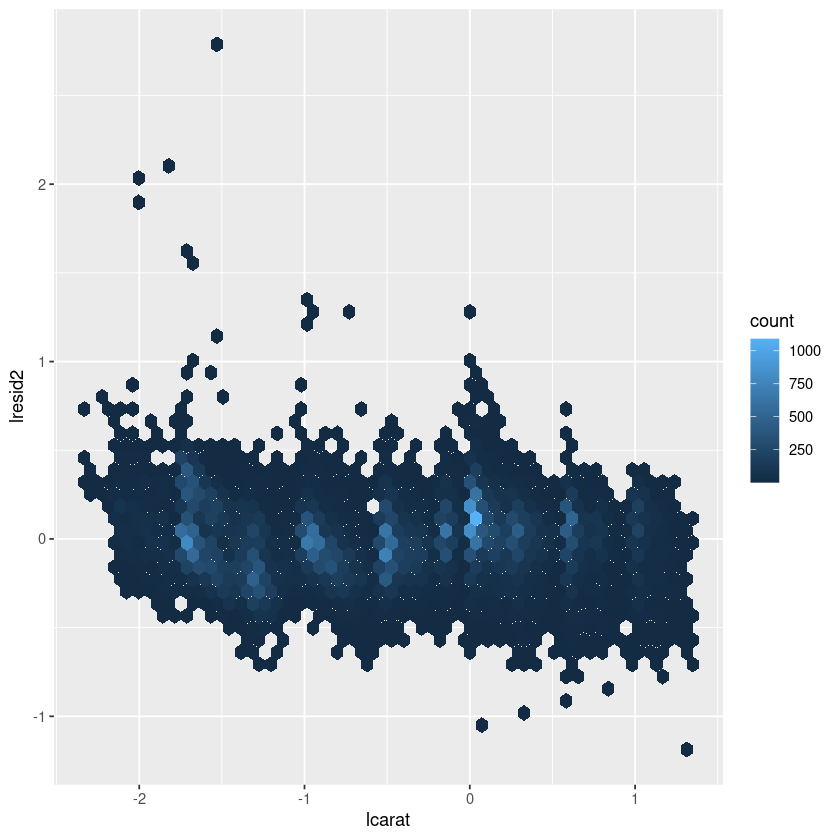

In [38]:
ggplot(diamonds2, aes(lcarat, lresid2)) +
  geom_hex(bins = 50)

In [39]:
lresid2_summary <- summarise(diamonds2,
  rmse = sqrt(mean(lresid2^2)),
  mae = mean(abs(lresid2)),
  p025 = quantile(lresid2, 0.025),
  p975 = quantile(lresid2, 0.975)
)
lresid2_summary

rmse,mae,p025,p975
<dbl>,<dbl>,<dbl>,<dbl>
0.191524,0.1491158,-0.3692446,0.3844299


While in some cases the model can be wrong, overall the model seems to perform well. The root mean squared error is 0.19 meaning that the average error is about -14%. Another summary statistics of errors is the mean absolute error (MAE), which is the mean of the absolute values of the errors. The MAE is 0.15, which is -11%. Finally, 95% of the residuals are between -0.37 and 0.38, which correspond to 23—31.

Whether you think that this is a good model depends on factors outside the statistical model itself. It will depend on the how the model is being used. I have no idea how to price diamonds, so this would be useful to me in order to understand a reasonable price range for a diamond, so I don’t get ripped off. However, if I were buying and selling diamonds as a business, I would probably require a better model.

## What affects the Numbe rof Daily Flights?

Let’s work through a similar process for a dataset that seems even
simpler at first glance: the number of flights that leave NYC per day.
This is a really small dataset—only 365 rows and 2 columns—and
we’re not going to end up with a fully realized model, but as you’ll
see, the steps along the way will help us better understand the data.
Let’s get started by counting the number of flights per day and visualizing it with ggplot2:

In [40]:
daily <- flights %>%
    mutate(date = make_date(year, month, day)) %>%
    group_by(date) %>%
    summarize(n = n())

`summarise()` ungrouping output (override with `.groups` argument)



In [41]:
daily

date,n
<date>,<int>
2013-01-01,842
2013-01-02,943
2013-01-03,914
2013-01-04,915
2013-01-05,720
2013-01-06,832
2013-01-07,933
2013-01-08,899
2013-01-09,902


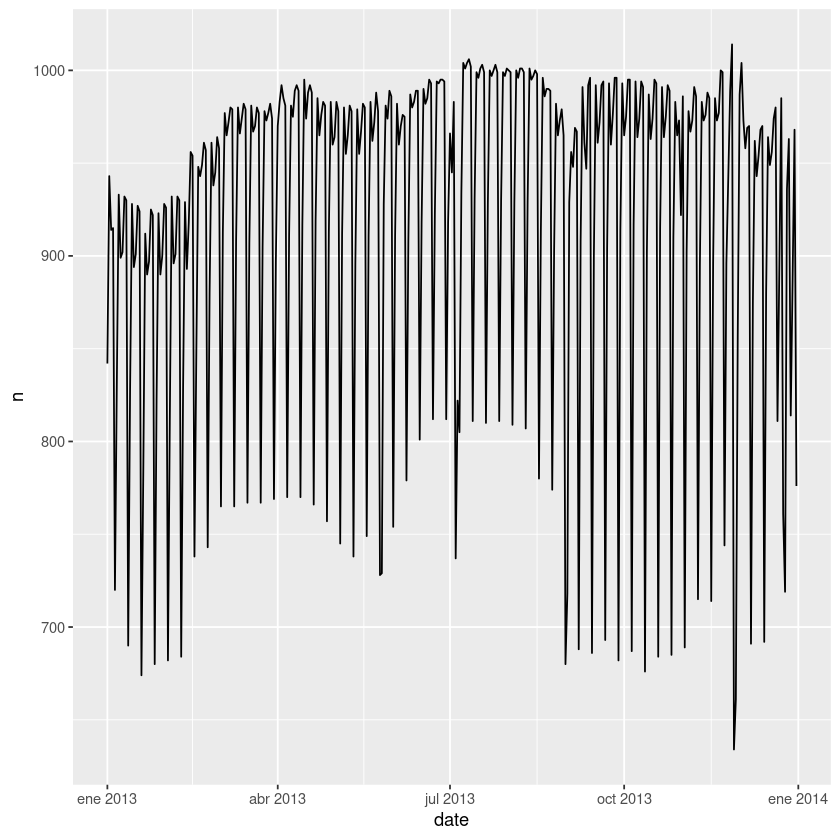

In [42]:
ggplot(daily, aes(date, n)) +
    geom_line()

#### Day of Week

Understanding the long-term trend is challenging because there’s a
very strong day-of-week effect that dominates the subtler patterns.
Let’s start by looking at the distribution of flight numbers by day of
week:

In [43]:
daily <- daily %>%
    mutate(wday = wday(date, label = TRUE))

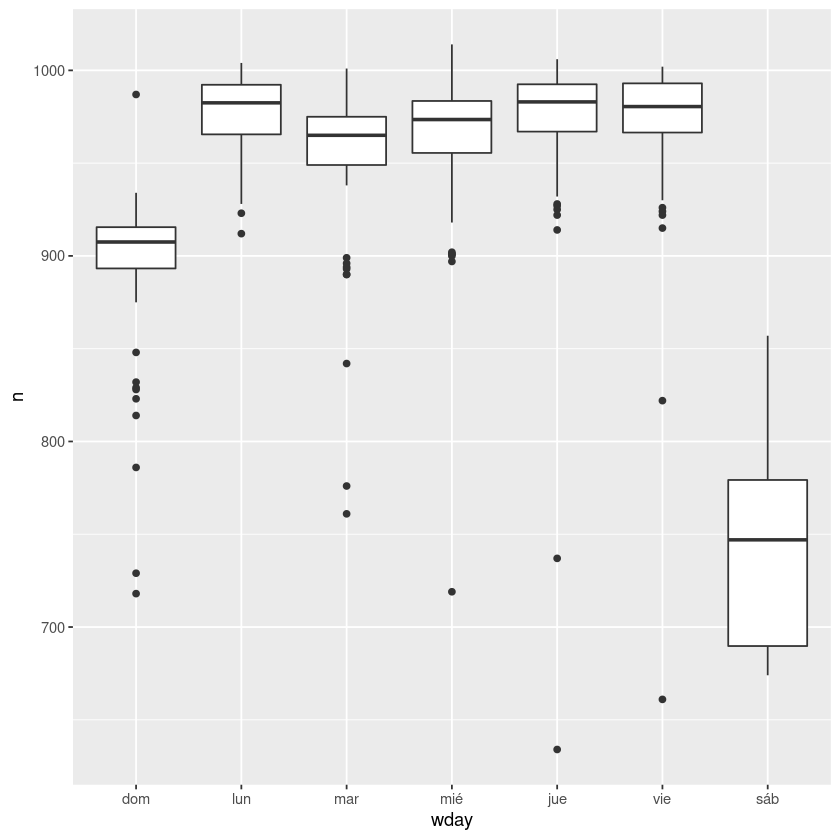

In [44]:
ggplot(daily, aes(wday, n)) +
    geom_boxplot()

There are fewer flights on weekends because most travel is for business. The effect is particularly pronounced on Saturday: you might
sometimes leave on Sunday for a Monday morning meeting, but it’s
very rare that you’d leave on Saturday as you’d much rather be at
home with your family.
One way to remove this strong pattern is to use a model. First, we fit
the model, and display its predictions overlaid on the original data:

In [45]:
mod <- lm(n ~ wday, data = daily)

In [46]:
grid <- daily %>%
    data_grid(wday) %>%
    add_predictions(mod, 'n')

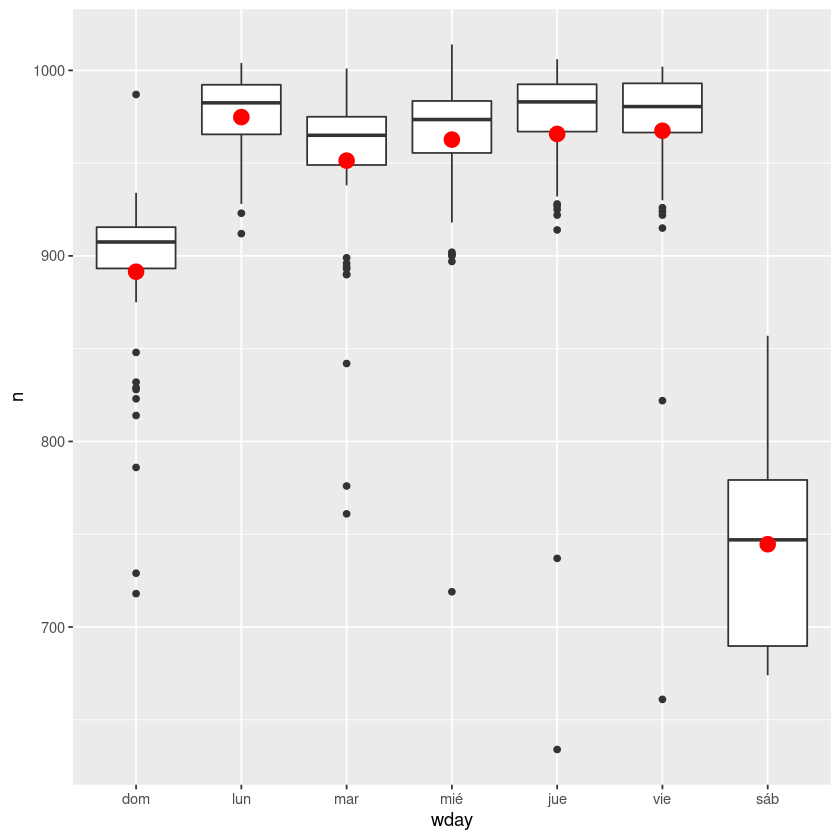

In [47]:
ggplot(daily, aes(wday, n)) +
    geom_boxplot() +
    geom_point(data = grid, color = 'red', size = 4)

Next we compute and visualize the residuals:

In [48]:
daily <- daily %>%
    add_residuals(mod)

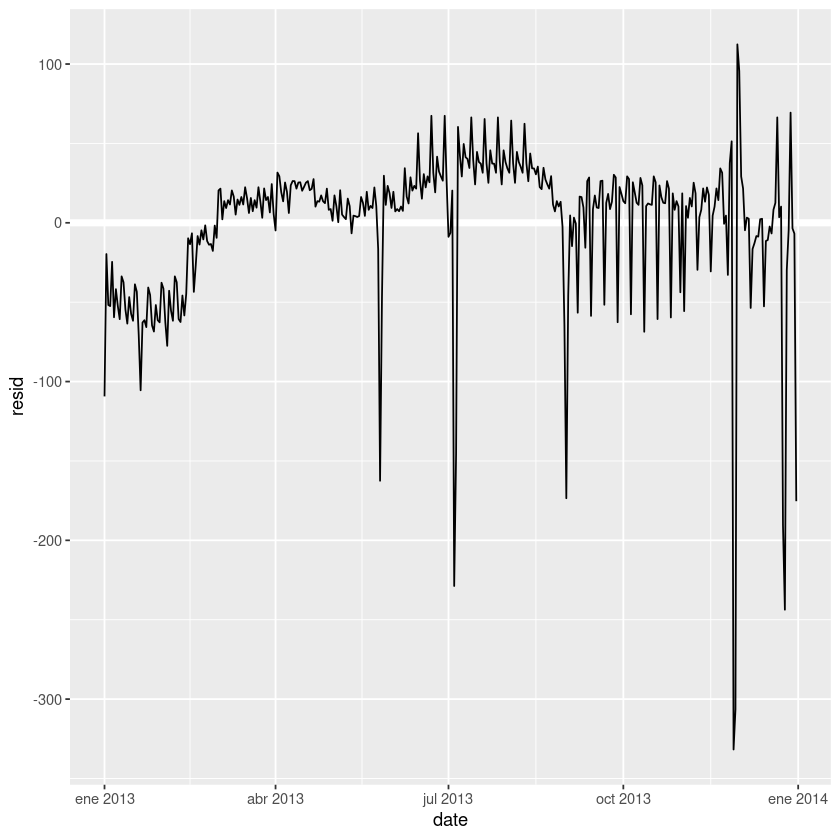

In [49]:
daily %>%
    ggplot(aes(date, resid)) +
    geom_ref_line(h = 0) +
    geom_line()

Note the change in the y-axis: now we are seeing the deviation from
the expected number of flights, given the day of week. This plot is
useful because now that we’ve removed much of the large day-of-
week effect, we can see some of the subtler patterns that remain:

* Our model seems to fail starting in June: you can still see a
strong regular pattern that our model hasn’t captured. Drawing
a plot with one line for each day of the week makes the cause
easier to see:

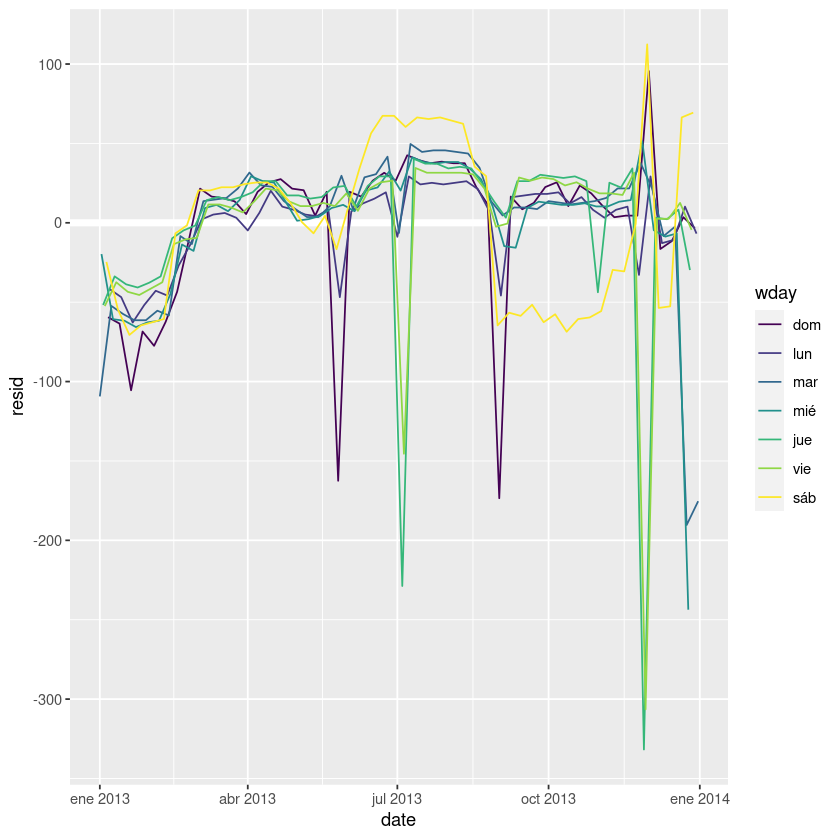

In [54]:
ggplot(daily, aes(date, resid, color = wday)) +
    geom_ref_line(h = 0) +
    geom_line()

Our model fails to accurately predict the number of flights on
Saturday: during summer there are more flights than we expect,
and during fall there are fewer. We’ll see how we can do better
to capture this pattern in the next section.

* There are some days with far fewer flights than expected:

In [55]:
daily %>%
    filter(resid < -100)

date,n,wday,resid
<date>,<int>,<ord>,<dbl>
2013-01-01,842,mar,-109.3585
2013-01-20,786,dom,-105.4808
2013-05-26,729,dom,-162.4808
2013-07-04,737,jue,-228.7500
2013-07-05,822,vie,-145.4615
2013-09-01,718,dom,-173.4808
2013-11-28,634,jue,-331.7500
2013-11-29,661,vie,-306.4615
2013-12-24,761,mar,-190.3585


If you’re familiar with American public holidays, you might spot
New Year’s Day, July 4th, Thanksgiving, and Christmas. There
are some others that don’t seem to correspond to public holidays.

* There seems to be some smoother long-term trend over the
course of a year. We can highlight that trend with
`geom_smooth()` :

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



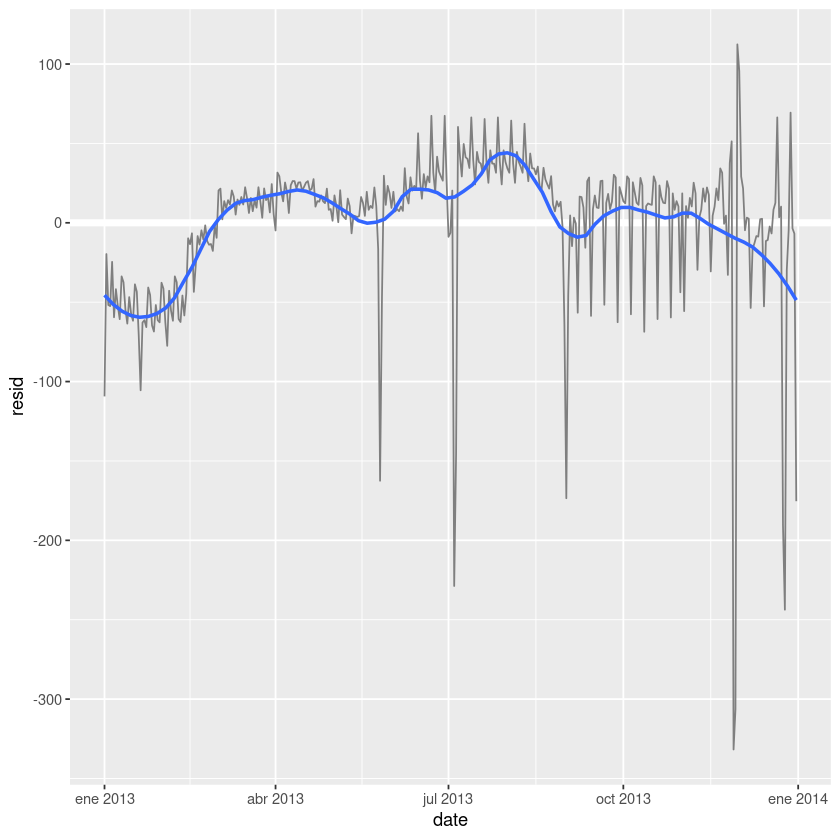

In [61]:
daily %>%
    ggplot(aes(date, resid)) +
    geom_ref_line(h = 0) +
    geom_line(color = 'grey50') +
    geom_smooth(se = FALSE,
                span = 0.20)

There are fewer flights in January (and December), and more in
summer (May–Sep). We can’t do much with this pattern quantitatively, because we only have a single year of data. But we can
use our domain knowledge to brainstorm potential explanations.

### Seasonal Saturday Effect

Let’s first tackle our failure to accurately predict the number of
flights on Saturday. A good place to start is to go back to the raw
numbers, focusing on Saturdays

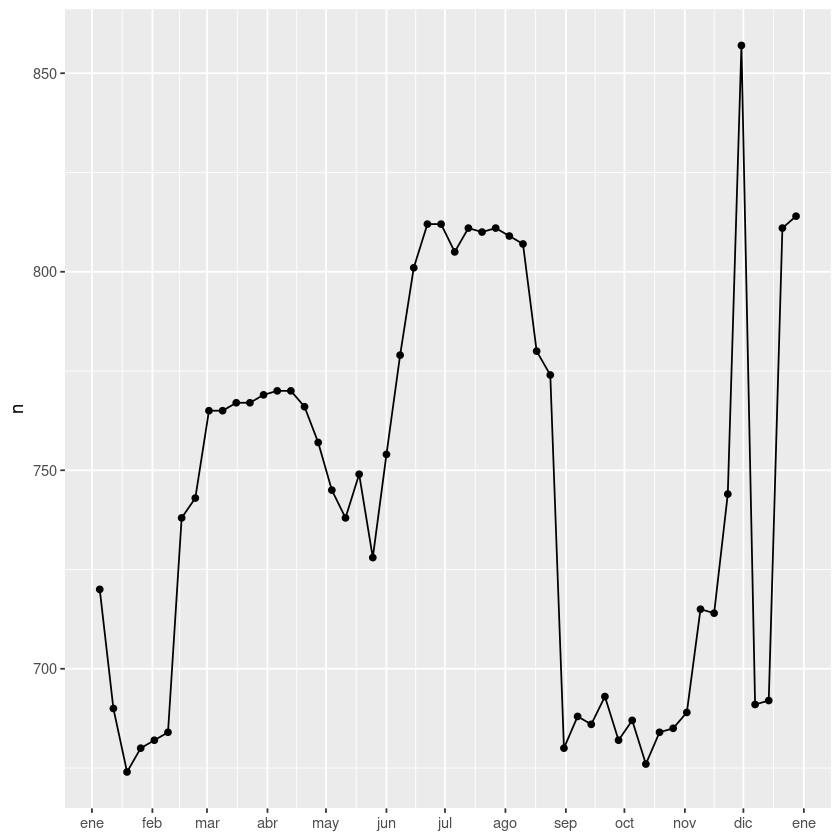

In [66]:
daily %>%
    filter(wday == 'sáb') %>%
    ggplot(aes(date, n)) +
        geom_point() +
        geom_line() +
        scale_x_date(NULL,
                     date_breaks = '1 month',
                     date_labels = '%b')

I suspect this pattern is caused by summer holidays: many people go
on holiday in the summer, and people don’t mind travelling on Saturdays for vacation. Looking at this plot, we might guess that summer holidays are from early June to late August. That seems to line
up fairly well with the state’s school terms: summer break in 2013
was June 26–September 9.

Why are there more Saturday flights in the spring than the fall? I
asked some American friends and they suggested that it’s less common to plan family vacations during the fall because of the big
Thanksgiving and Christmas holidays. We don’t have the data to
know for sure, but it seems like a plausible working hypothesis.

Let’s create a “term” variable that roughly captures the three school
terms, and check our work with a plot:

In [67]:
term <- function(date) {
    cut(date,
        breaks = ymd(20130101, 20130605, 20130825, 20140101),
        labels = c('spring', 'summer', 'fall'))
}

In [68]:
daily <- daily %>%
    mutate(term = term(date))

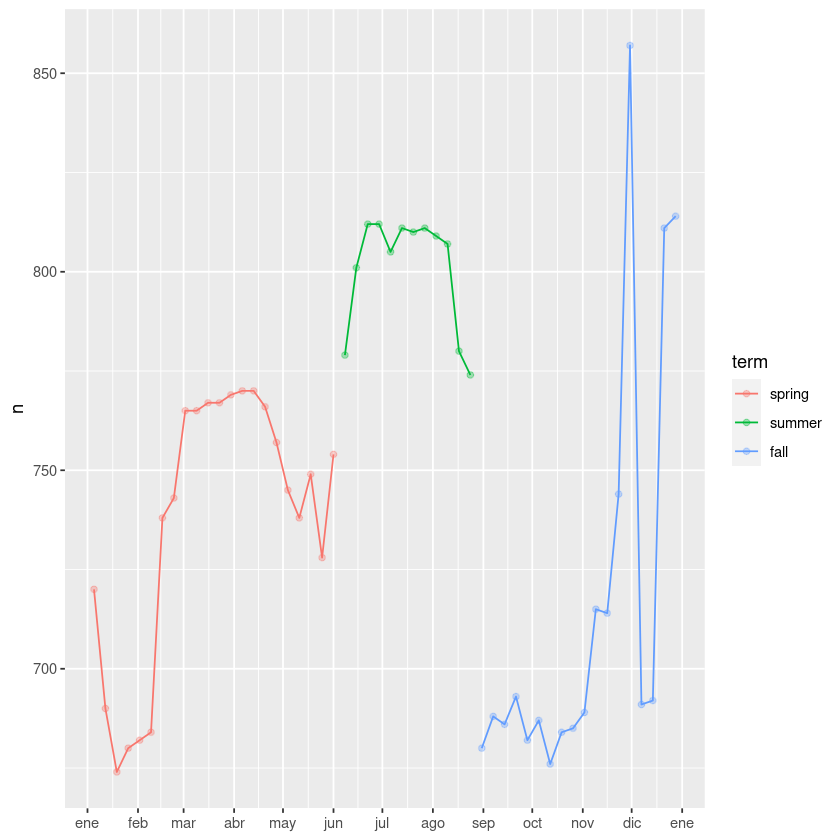

In [70]:
daily %>%
    filter(wday == 'sáb') %>%
    ggplot(aes(date, n, color = term)) +
    geom_point(alpha = 1/3) +
    geom_line() +
    scale_x_date(NULL,
                 date_breaks = '1 month',
                 date_labels = '%b')

(I manually tweaked the dates to get nice breaks in the plot. Using a
visualization to help you understand what your function is doing is
a really powerful and general technique.)

It’s useful to see how this new variable affects the other days of the
week:

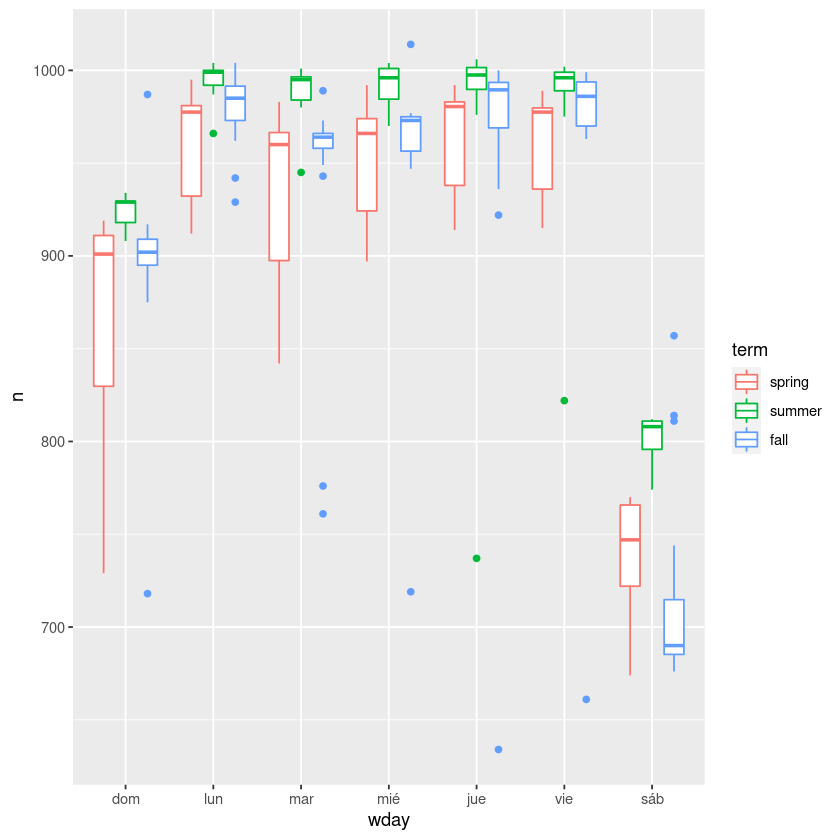

In [71]:
daily %>%
    ggplot(aes(wday, n, color = term)) +
    geom_boxplot()

It looks like there is significant variation across the terms, so fitting a
separate day-of-week effect for each term is reasonable. This
improves our model, but not as much as we might hope:

In [72]:
mod1 <- lm(n ~ wday, data = daily)
mod2 <- lm(n ~ wday * term, data = daily)

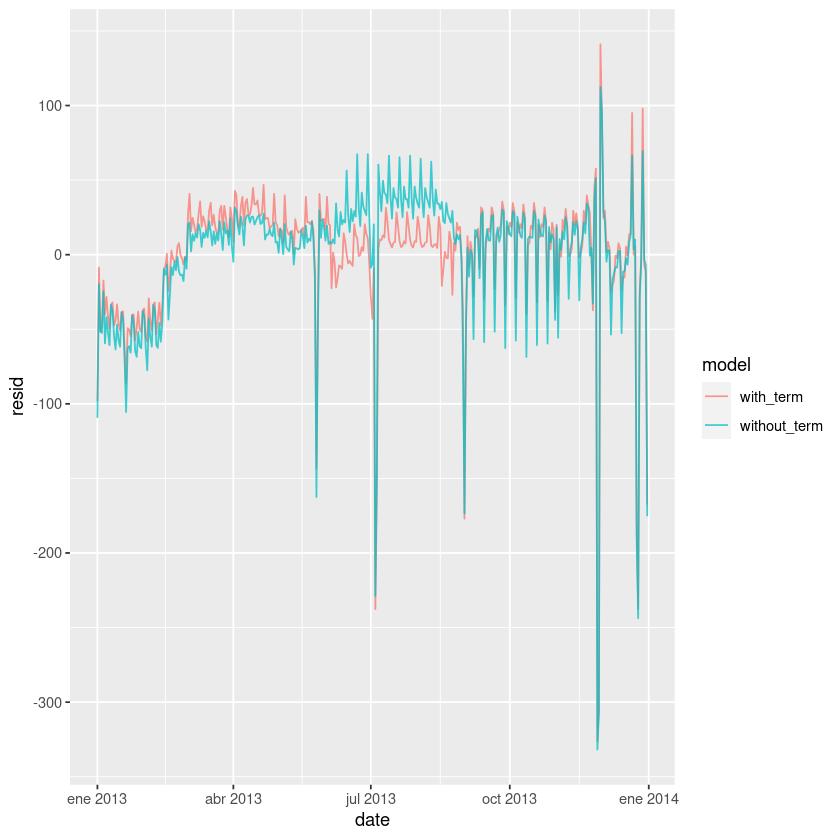

In [73]:
daily %>%
    gather_residuals(without_term = mod1, with_term = mod2) %>%
    ggplot(aes(date, resid, color = model)) +
        geom_line(alpha = 3/4)

We can see the problem by overlaying the predictions from the
model onto the raw data:

In [74]:
grid <- daily %>%
    data_grid(wday, term) %>%
    add_predictions(mod2, 'n')

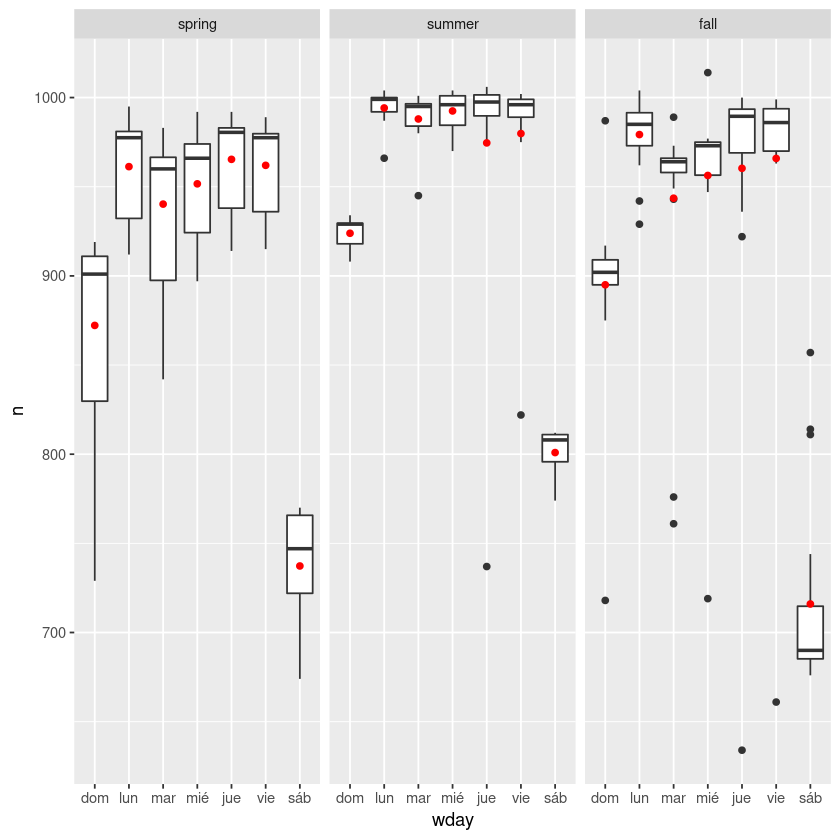

In [75]:
ggplot(daily, aes(wday, n)) +
    geom_boxplot() +
    geom_point(data = grid, color = 'red') +
    facet_wrap(~term)

Our model is finding the mean effect, but we have a lot of big outliers, so the mean tends to be far away from the typical value. We can
alleviate this problem by using a model that is robust to the effect of
outliers: `MASS::rlm()` . This greatly reduces the impact of the outliers on our estimates, and gives a model that does a good job of
removing the day-of-week pattern:

In [78]:
mod3 <- MASS::rlm(n ~ wday * term, data = daily)

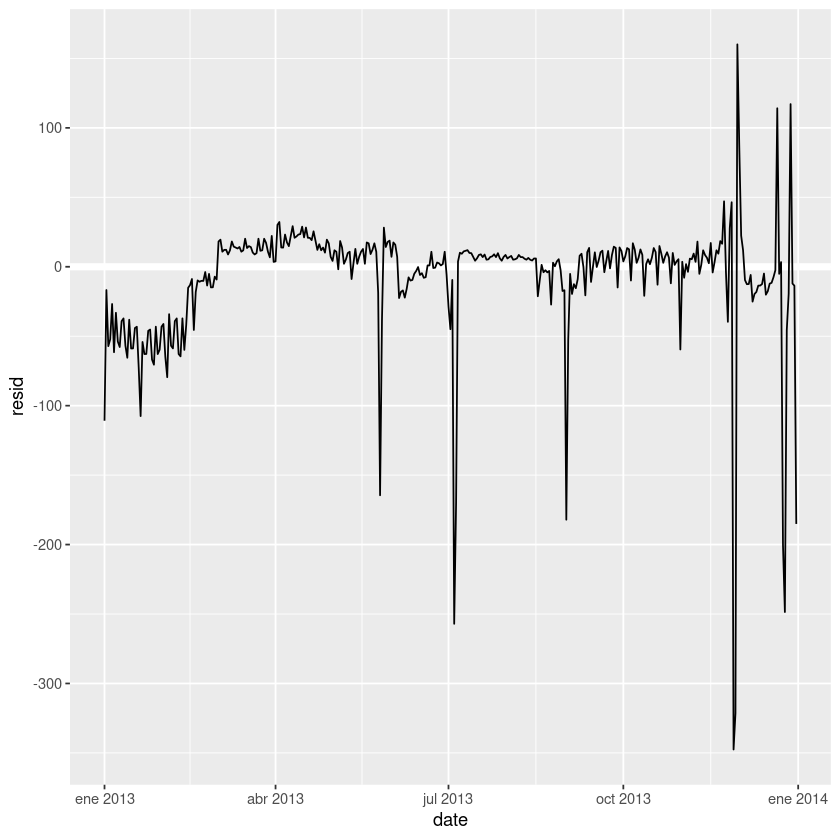

In [79]:
daily %>%
    add_residuals(mod3, 'resid') %>%
    ggplot(aes(date, resid)) +
    geom_hline(yintercept = 0, size = 2, color = 'white') +
    geom_line()

It’s now much easier to see the long-term trend, and the positive and
negative outliers.

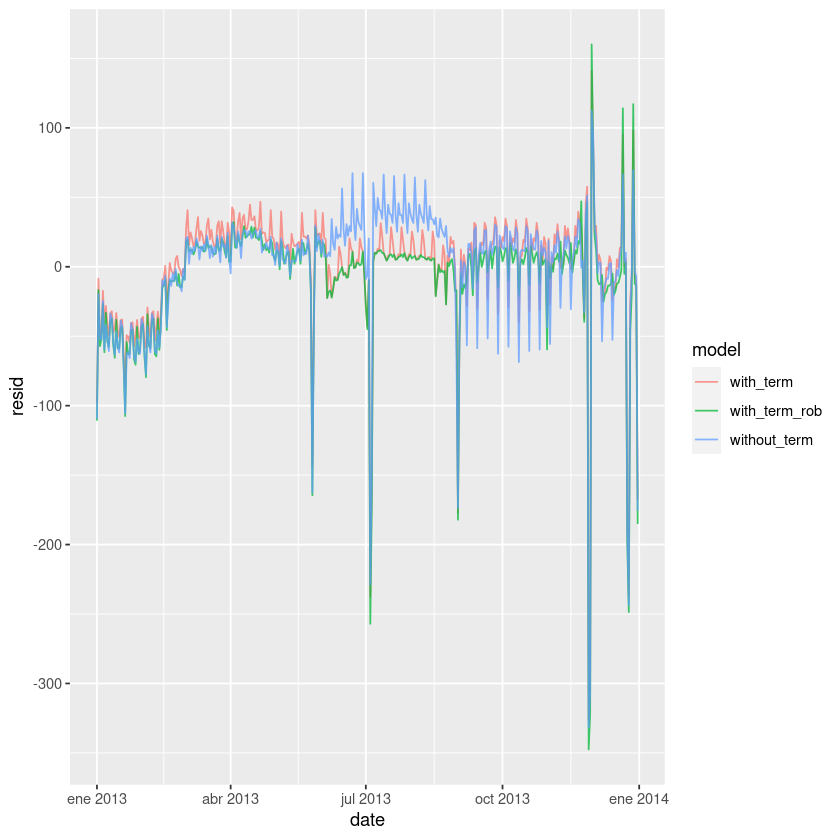

In [80]:
daily %>%
    gather_residuals(without_term = mod1, with_term = mod2, with_term_rob = mod3) %>%
    ggplot(aes(date, resid, color = model)) +
        geom_line(alpha = 3/4)

### Computed Variables

If you’re experimenting with many models and many visualizations,
it’s a good idea to bundle the creation of variables up into a function
so there’s no chance of accidentally applying a different transformation in different places. For example, we could write:

In [81]:
compute_vaes <- function(data) {
    data %>%
        mutate(term = term(date),
               wday = wday(date, label = TRUE))
}

Another option is to put the transformations directly in the model
formula:

In [82]:
wday2 <- function(x) wday(x, label = TRUE)
mod3 <- lm(n ~ wday2(date) * term(date), data = daily)

Either approach is reasonable. Making the transformed variable
explicit is useful if you want to check your work, or use them in a
visualization. But you can’t easily use transformations (like splines)
that return multiple columns. Including the transformations in the
model function makes life a little easier when you’re working with
many different datasets because the model is self-contained.

## Time of Year: An Alternative Approach

In the previous section we used our domain knowledge (how the US
school term affects travel) to improve the model. An alternative to
making our knowledge explicit in the model is to give the data more
room to speak. We could use a more flexible model and allow that to
capture the pattern we’re interested in. A simple linear trend isn’t
adequate, so we could try using a natural spline to fit a smooth
curve across the year:

In [83]:
library(splines)

In [84]:
mod <- MASS::rlm(n ~ wday * ns(date, 5), data = daily)

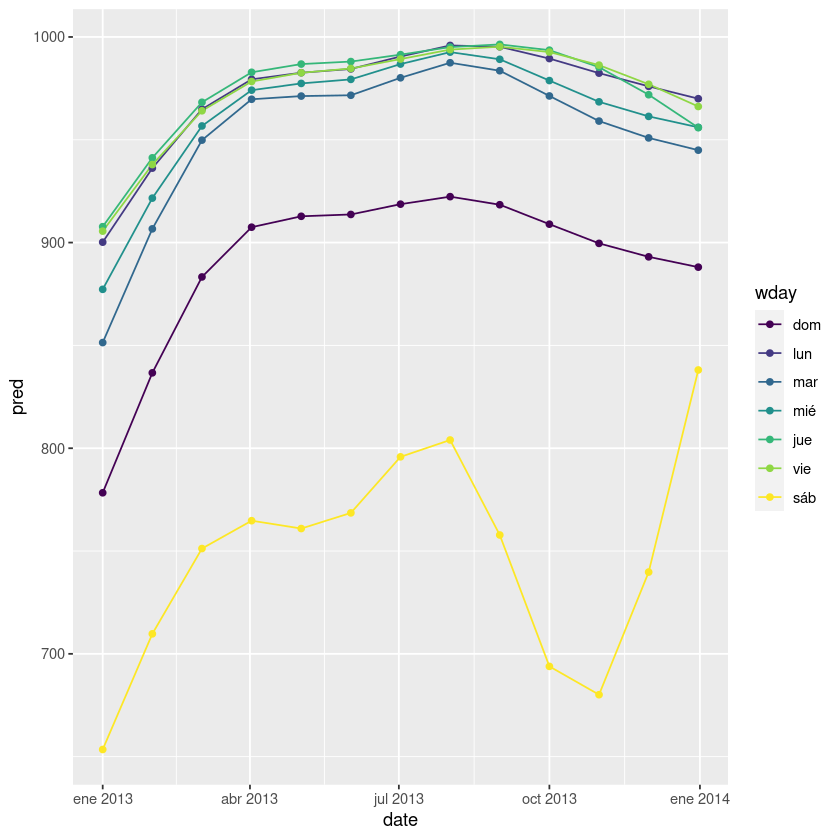

In [100]:
daily %>%
    data_grid(wday, date = seq_range(date, n = 13)) %>%
    add_predictions(mod) %>%
    ggplot(aes(date, pred, color = wday)) +
        geom_line() +
        geom_point()

We see a strong pattern in the numbers of Saturday flights. This is
reassuring, because we also saw that pattern in the raw data. It’s a
good sign when you get the same signal from different approaches.

### __Exercises__

1. __Use your Google sleuthing skills to brainstorm why there were
fewer than expected flights on January 20, May 26, and Septem‐
ber 1. (Hint: they all have the same explanation.) How would
these days generalize to another year?__

These are the Sundays before Monday holidays Martin Luther King Jr. Day, Memorial Day, and Labor Day. For other years, use the dates of the holidays for those years—the third Monday of January for Martin Luther King Jr. Day, the last Monday of May for Memorial Day, and the first Monday in September for Labor Day.

2. __What do the three days with high positive residuals represent?
How would these days generalize to another year?__

In [101]:
daily %>%
    top_n(3, resid)

date,n,wday,resid,term
<date>,<int>,<ord>,<dbl>,<fct>
2013-11-30,857,sáb,112.38462,fall
2013-12-01,987,dom,95.51923,fall
2013-12-28,814,sáb,69.38462,fall


The top three days correspond to the Saturday after Thanksgiving (November 30th), the Sunday after Thanksgiving (December 1st), and the Saturday after Christmas (December 28th).

We could generalize these to other years using the dates of those holidays on those years.

3. __Create a new variable that splits the wday variable into terms,
but only for Saturdays, i.e., it should have Thurs , Fri , but Satsummer , Sat-spring , Sat-fall . How does this model compare
with the model with every combination of wday and term ?__

In [102]:
daily <- daily %>%
  mutate(
    wday2 =
      case_when(
        wday == "Sat" & term == "summer" ~ "Sat-summer",
        wday == "Sat" & term == "fall" ~ "Sat-fall",
        wday == "Sat" & term == "spring" ~ "Sat-spring",
        TRUE ~ as.character(wday)
      )
  )

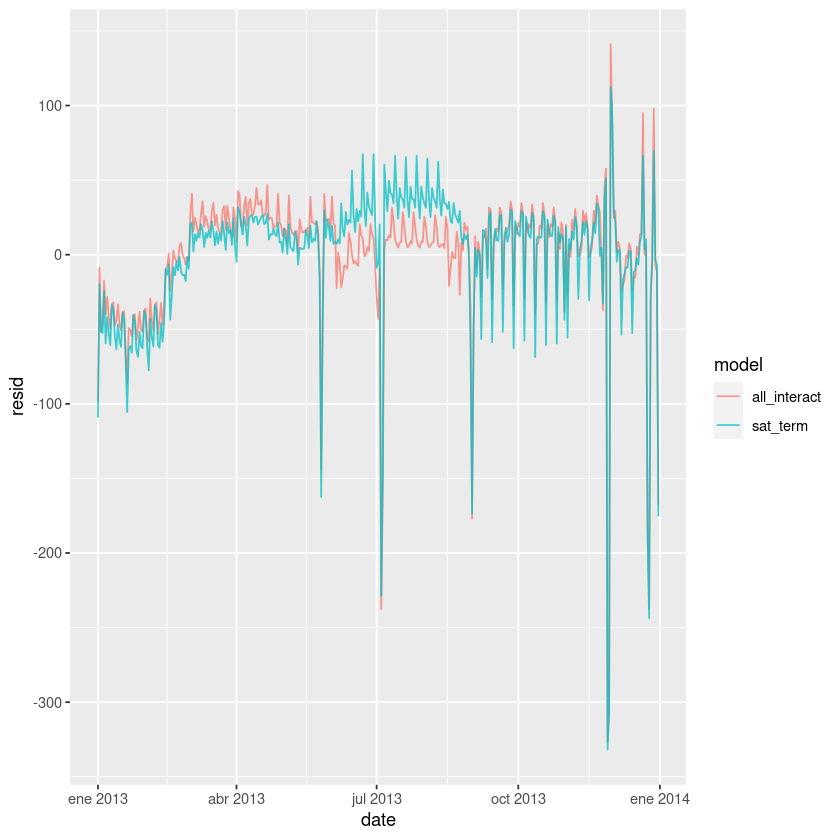

In [103]:
mod3 <- lm(n ~ wday2, data = daily)

daily %>%
  gather_residuals(sat_term = mod3, all_interact = mod2) %>%
  ggplot(aes(date, resid, colour = model)) +
  geom_line(alpha = 0.75)

I think the overlapping plot is hard to understand. If we are interested in the differences, it is better to plot the differences directly. In this code, I use `spread_residuals()` to add one column per model, rather than `gather_residuals()` which creates a new row for each model.

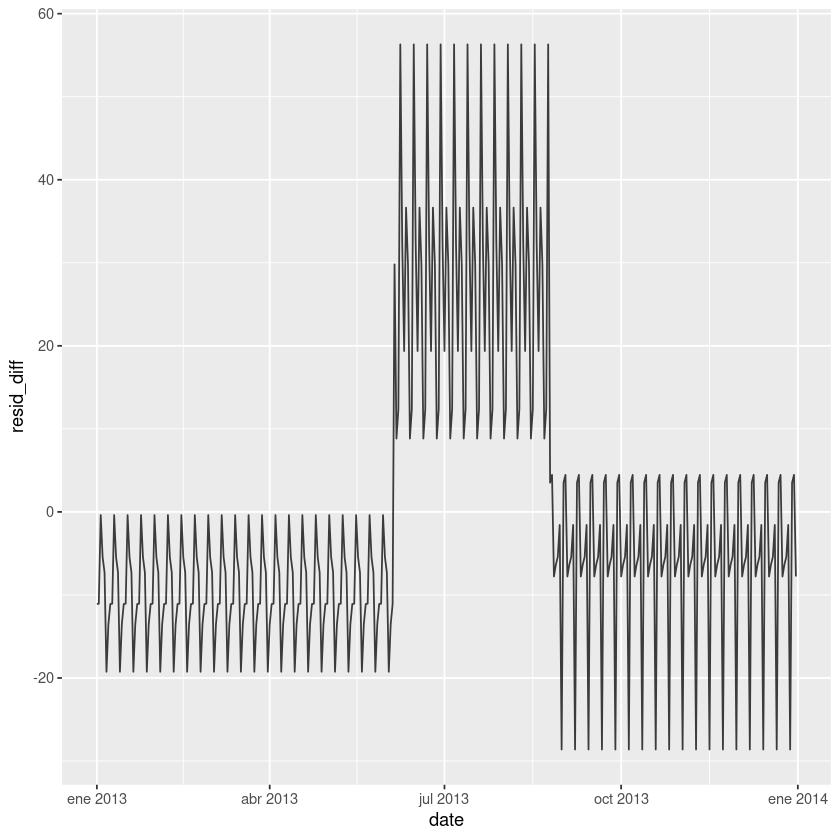

In [104]:
daily %>%
  spread_residuals(sat_term = mod3, all_interact = mod2) %>%
  mutate(resid_diff = sat_term - all_interact) %>%
  ggplot(aes(date, resid_diff)) +
  geom_line(alpha = 0.75)

The model with terms × Saturday has higher residuals in the fall and lower residuals in the spring than the model with all interactions.

Comparing models, mod3 has a lower R2
and regression standard error, ^σ, despite using fewer variables. More importantly for prediction purposes, this model has a higher AIC, which is an estimate of the out of sample error.

4. __Create a new wday variable that combines the day of week, term (for Saturdays), and public holidays. What do the residuals of that model look like?__

In [106]:
holidays_2013 <-
  tribble(
    ~holiday, ~date,
    "New Year's Day", 20130101,
    "Martin Luther King Jr. Day", 20130121,
    "Washington's Birthday", 20130218,
    "Memorial Day", 20130527,
    "Independence Day", 20130704,
    "Labor Day", 20130902,
    "Columbus Day", 20131028,
    "Veteran's Day", 20131111,
    "Thanksgiving", 20131128,
    "Christmas", 20131225
  ) %>%
  mutate(date = lubridate::ymd(date))

The model could include a single dummy variable which indicates a day was a public holiday. Alternatively, I could include a dummy variable for each public holiday. I would expect that Veteran’s Day and Washington’s Birthday have a different effect on travel than Thanksgiving, Christmas, and New Year’s Day.

Another question is whether and how I should handle the days before and after holidays. Travel could be lighter on the day of the holiday, but heavier the day before or after.

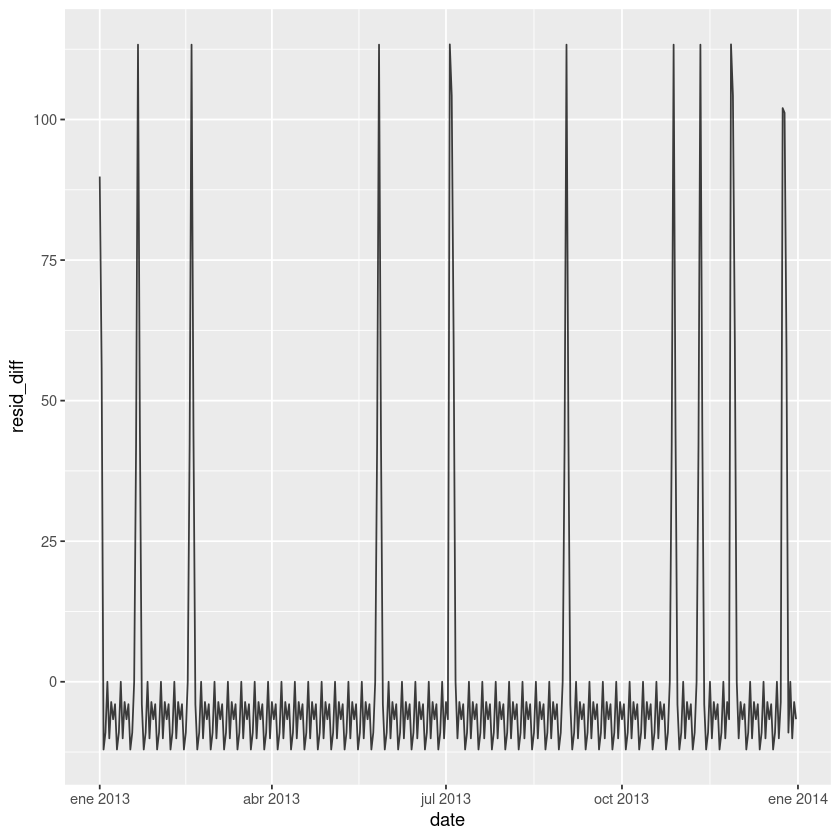

In [107]:
daily <- daily %>%
  mutate(
    wday3 =
      case_when(
        date %in% (holidays_2013$date - 1L) ~ "day before holiday",
        date %in% (holidays_2013$date + 1L) ~ "day after holiday",
        date %in% holidays_2013$date ~ "holiday",
        .$wday == "Sat" & .$term == "summer" ~ "Sat-summer",
        .$wday == "Sat" & .$term == "fall" ~ "Sat-fall",
        .$wday == "Sat" & .$term == "spring" ~ "Sat-spring",
        TRUE ~ as.character(.$wday)
      )
  )

mod4 <- lm(n ~ wday3, data = daily)

daily %>%
  spread_residuals(resid_sat_terms = mod3, resid_holidays = mod4) %>%
  mutate(resid_diff = resid_holidays - resid_sat_terms) %>%
  ggplot(aes(date, resid_diff)) +
  geom_line(alpha = 0.75)

5. __What happens if you fit a day of week effect that varies by month (i.e., n ~ wday * month)? Why is this not very helpful?__

In [108]:
daily <- mutate(daily, month = factor(lubridate::month(date)))
mod6 <- lm(n ~ wday * month, data = daily)
print(summary(mod6))


Call:
lm(formula = n ~ wday * month, data = daily)

Residuals:
   Min     1Q Median     3Q    Max 
-269.2   -5.0    1.5    8.8  113.2 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     867.4000     7.5983 114.157  < 2e-16 ***
wday.L          -64.0744    20.8737  -3.070 0.002353 ** 
wday.Q         -165.6001    20.1555  -8.216 7.77e-15 ***
wday.C          -68.2591    20.3115  -3.361 0.000885 ***
wday^4          -92.0814    20.4991  -4.492 1.03e-05 ***
wday^5            9.7925    19.7334   0.496 0.620111    
wday^6          -20.4376    18.9922  -1.076 0.282802    
month2           23.7071    10.9946   2.156 0.031912 *  
month3           67.8857    10.7456   6.318 1.04e-09 ***
month4           74.5929    10.8292   6.888 3.70e-11 ***
month5           56.2786    10.7456   5.237 3.20e-07 ***
month6           80.3071    10.8292   7.416 1.43e-12 ***
month7           77.1143    10.7456   7.176 6.39e-12 ***
month8           81.6357    10.7456   7.597 4.52e-1



If we fit a day of week effect that varies by month, there will be 12 * 7 = 84 parameters in the model. Since each month has only four to five weeks, each of these day of week ×
month effects is the average of only four or five observations. These estimates have large standard errors and likely not generalize well beyond the sample data, since they are estimated from only a few observations.

6. __What would you expect the model n ~ wday + ns(date, 5) to look like? Knowing what you know about the data, why would you expect it to be not particularly effective?__

In [109]:
mod7 <- lm(n ~ wday + ns(date, 5), data = daily)
mod8 <- lm(n ~ wday * ns(date, 5), data = daily)

The residuals of the model that does not interact day of week with time of year (mod7) are larger than those of the model that does (mod8). The model mod7 underestimates weekends during the summer and overestimates weekends during the autumn.

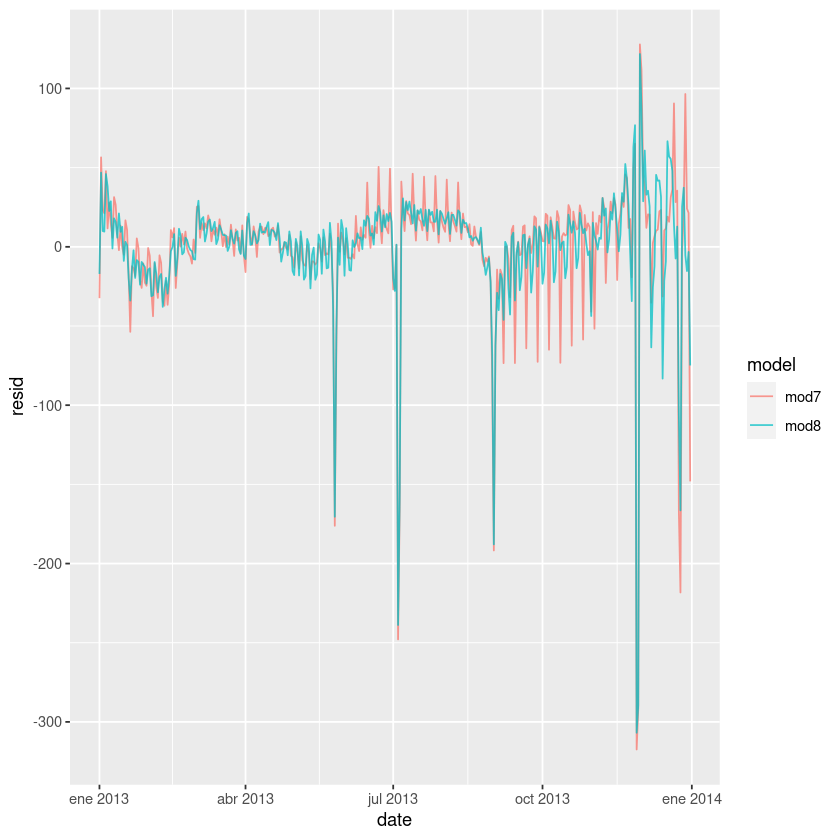

In [110]:
daily %>%
  gather_residuals(mod7, mod8) %>%
  ggplot(aes(x = date, y = resid, color = model)) +
  geom_line(alpha = 0.75)

7. __We hypothesized that people leaving on Sundays are more likely to be business travelers who need to be somewhere on Monday. Explore that hypothesis by seeing how it breaks down based on distance and time: if it’s true, you’d expect to see more Sunday evening flights to places that are far away.__

Comparing the average distances of flights by day of week, Sunday flights are the second longest. Saturday flights are the longest on average. Saturday may have the longest flights on average because there are fewer regularly scheduled short business/commuter flights on the weekends but that is speculation.

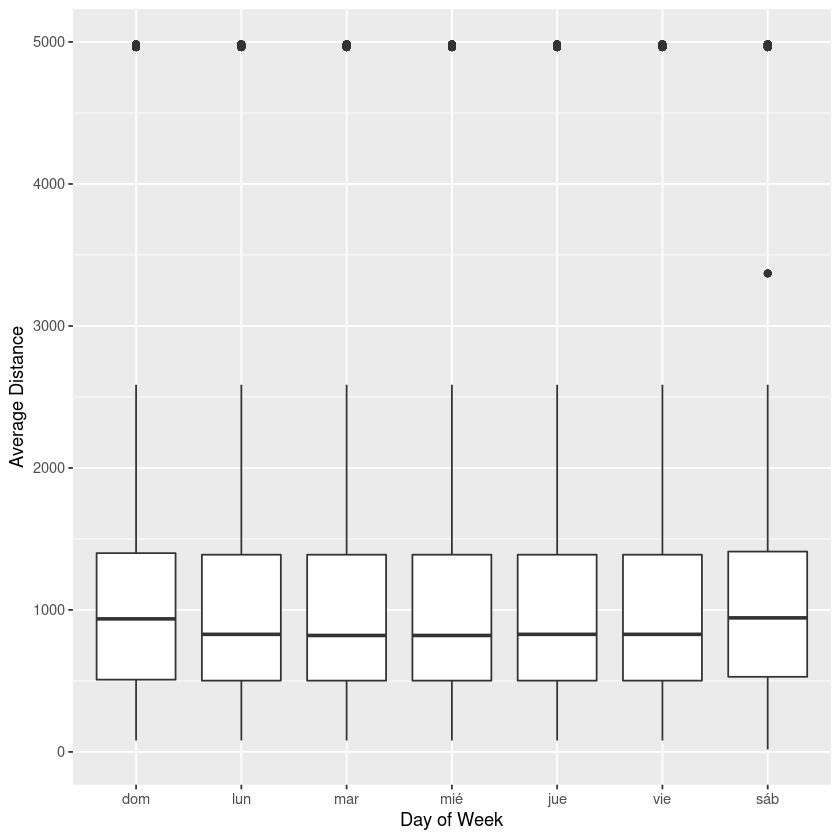

In [111]:
flights %>%
  mutate(
    date = make_date(year, month, day),
    wday = wday(date, label = TRUE)
  ) %>%
  ggplot(aes(y = distance, x = wday)) +
  geom_boxplot() +
  labs(x = "Day of Week", y = "Average Distance")

Hide outliers.

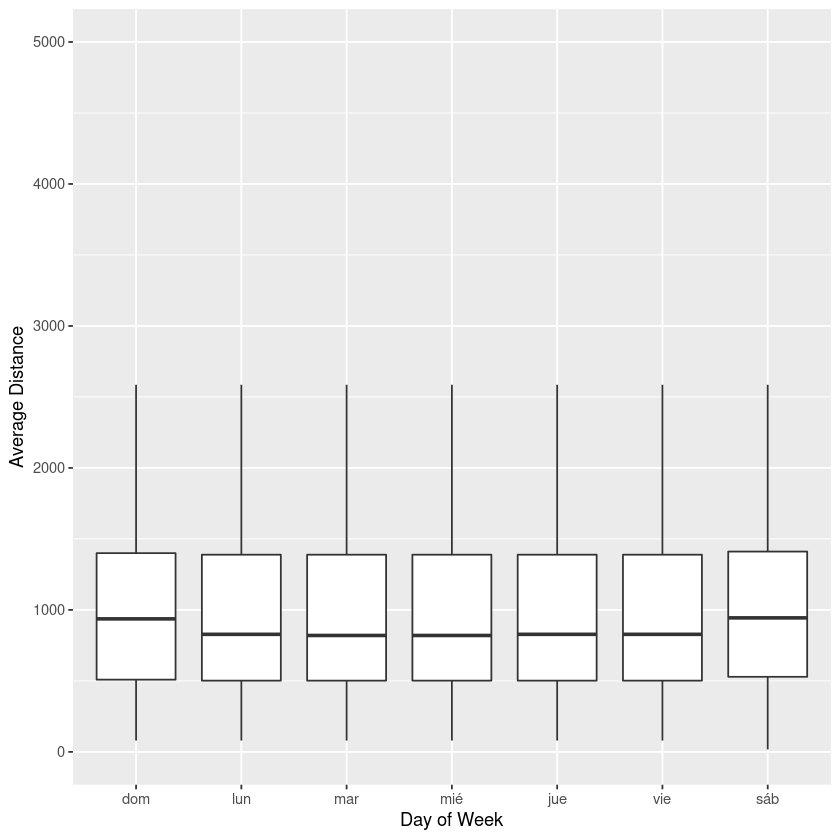

In [112]:
flights %>%
  mutate(
    date = make_date(year, month, day),
    wday = wday(date, label = TRUE)
  ) %>%
  ggplot(aes(y = distance, x = wday)) +
  geom_boxplot(outlier.shape = NA) +
  labs(x = "Day of Week", y = "Average Distance")

Try pointrange with mean and standard error of the mean (sd / sqrt(n)).

No summary function supplied, defaulting to `mean_se()`



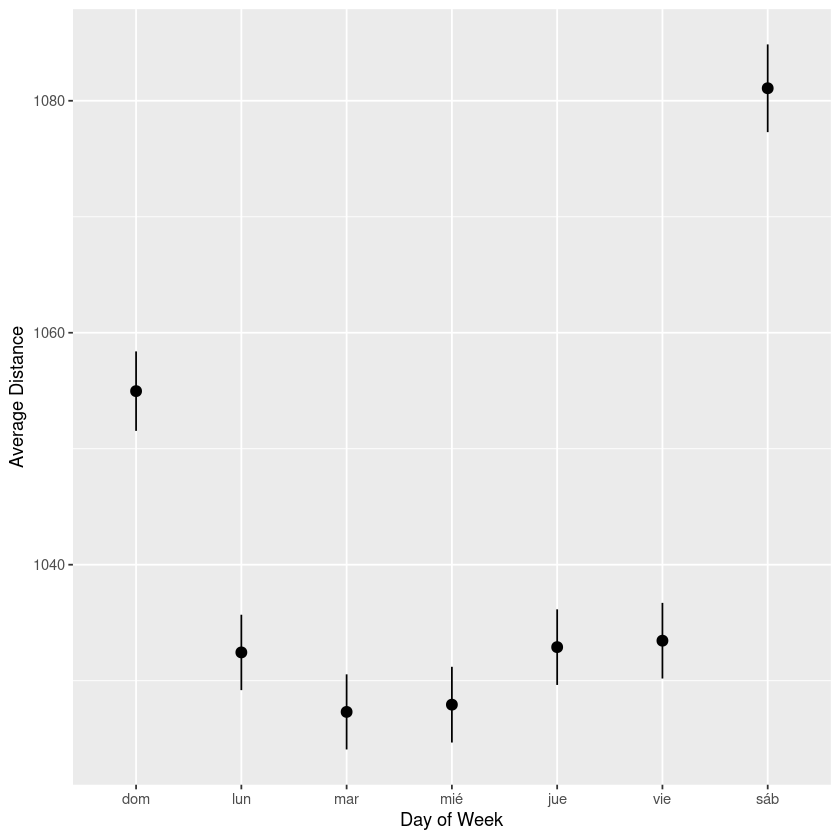

In [113]:
flights %>%
  mutate(
    date = make_date(year, month, day),
    wday = wday(date, label = TRUE)
  ) %>%
  ggplot(aes(y = distance, x = wday)) +
  stat_summary() +
  labs(x = "Day of Week", y = "Average Distance")

Try pointrange with mean and standard error of the mean (sd / sqrt(n)).

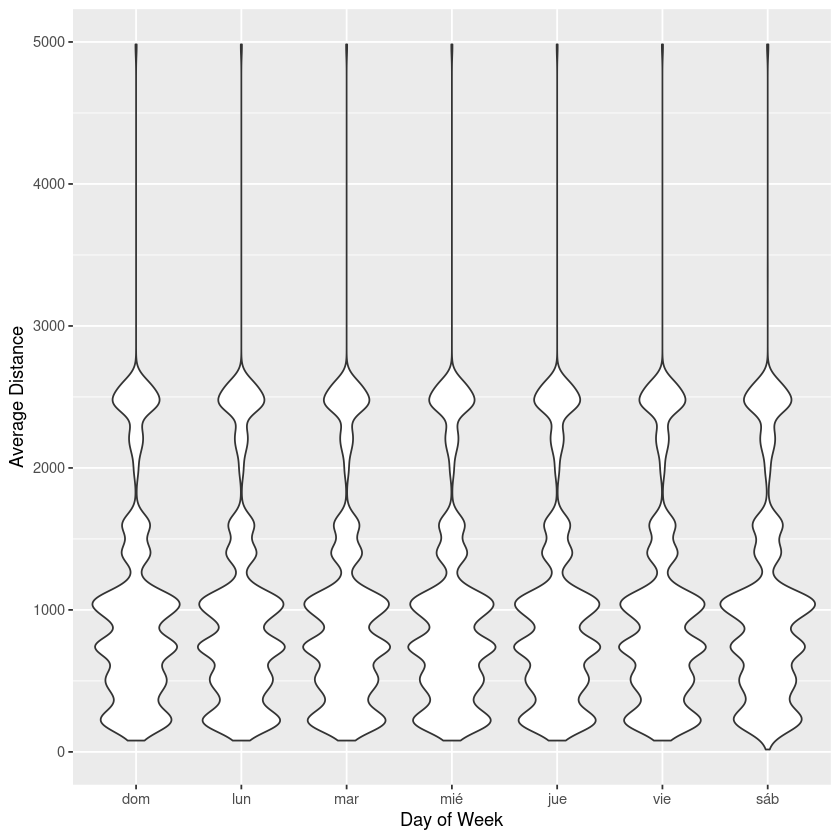

In [114]:
flights %>%
  mutate(
    date = make_date(year, month, day),
    wday = wday(date, label = TRUE)
  ) %>%
  ggplot(aes(y = distance, x = wday)) +
  geom_violin() +
  labs(x = "Day of Week", y = "Average Distance")

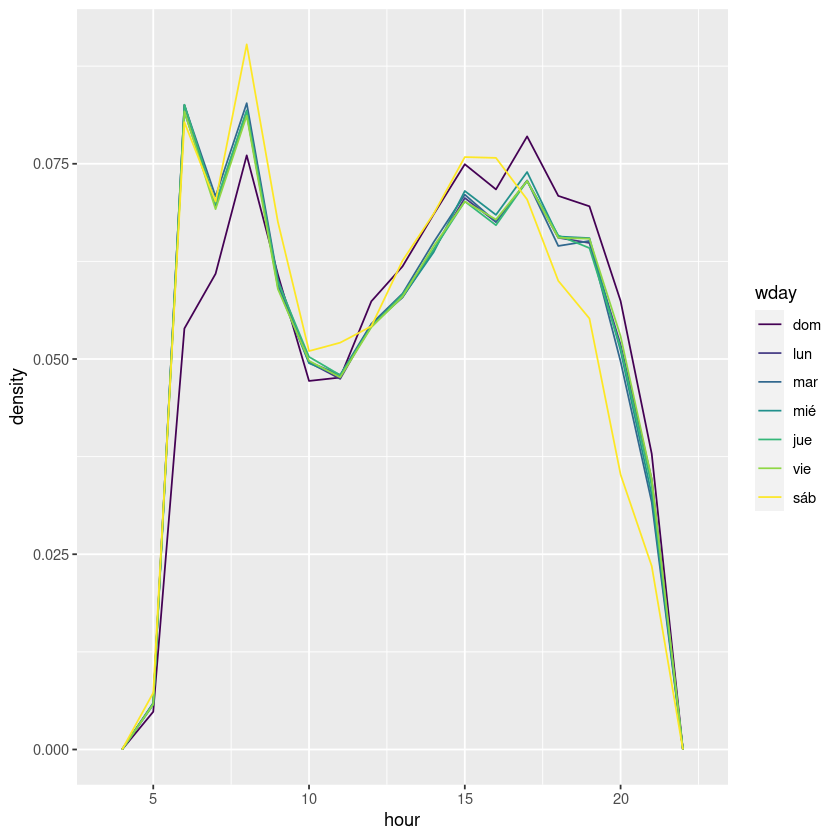

In [115]:
flights %>%
  mutate(
    date = make_date(year, month, day),
    wday = wday(date, label = TRUE)
  ) %>%
  filter(
    distance < 3000,
    hour >= 5, hour <= 21
  ) %>%
  ggplot(aes(x = hour, color = wday, y = ..density..)) +
  geom_freqpoly(binwidth = 1)

`summarise()` regrouping output by 'wday' (override with `.groups` argument)



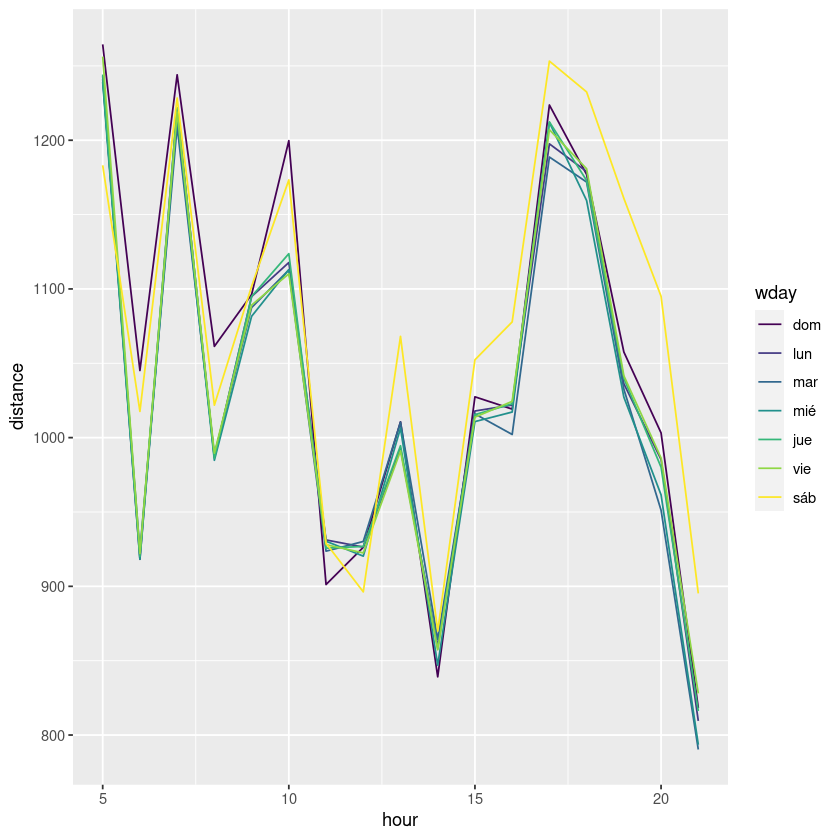

In [116]:
flights %>%
  mutate(
    date = make_date(year, month, day),
    wday = wday(date, label = TRUE)
  ) %>%
  filter(
    distance < 3000,
    hour >= 5, hour <= 21
  ) %>%
  group_by(wday, hour) %>%
  summarise(distance = mean(distance)) %>%
  ggplot(aes(x = hour, color = wday, y = distance)) +
  geom_line()

`summarise()` regrouping output by 'wday' (override with `.groups` argument)



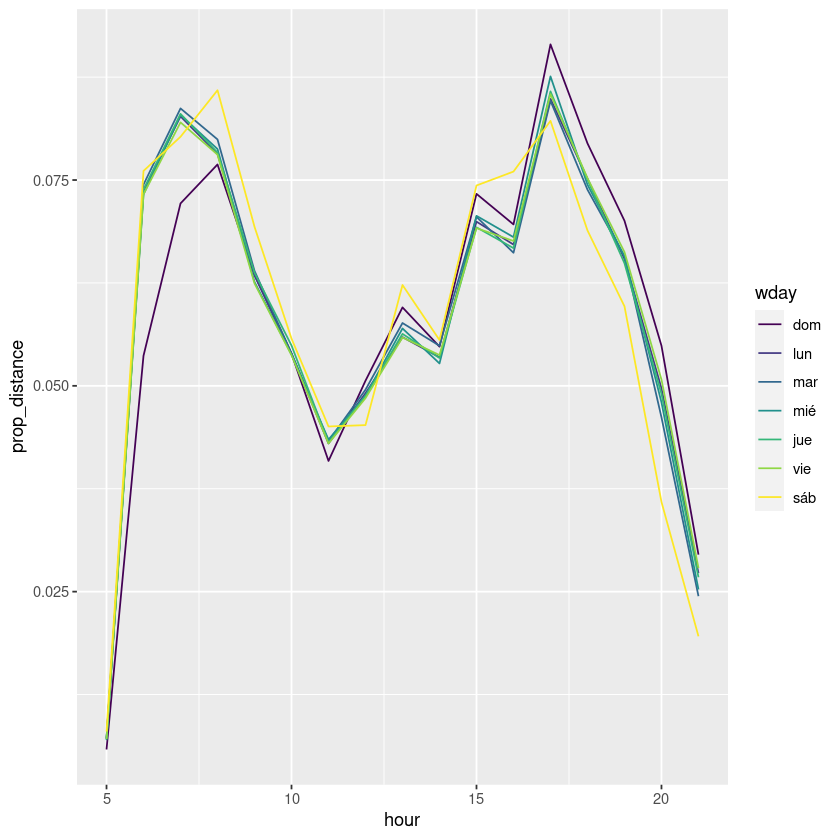

In [117]:
flights %>%
  mutate(
    date = make_date(year, month, day),
    wday = wday(date, label = TRUE)
  ) %>%
  filter(
    distance < 3000,
    hour >= 5, hour <= 21
  ) %>%
  group_by(wday, hour) %>%
  summarise(distance = sum(distance)) %>%
  group_by(wday) %>%
  mutate(prop_distance = distance / sum(distance)) %>%
  ungroup() %>%
  ggplot(aes(x = hour, color = wday, y = prop_distance)) +
  geom_line()

8. __It’s a little frustrating that Sunday and Saturday are on separate ends of the plot. Write a small function to set the levels of the factor so that the week starts on Monday.__

In [118]:
monday_first <- function(x) {
  fct_relevel(x, levels(x)[-1])
}

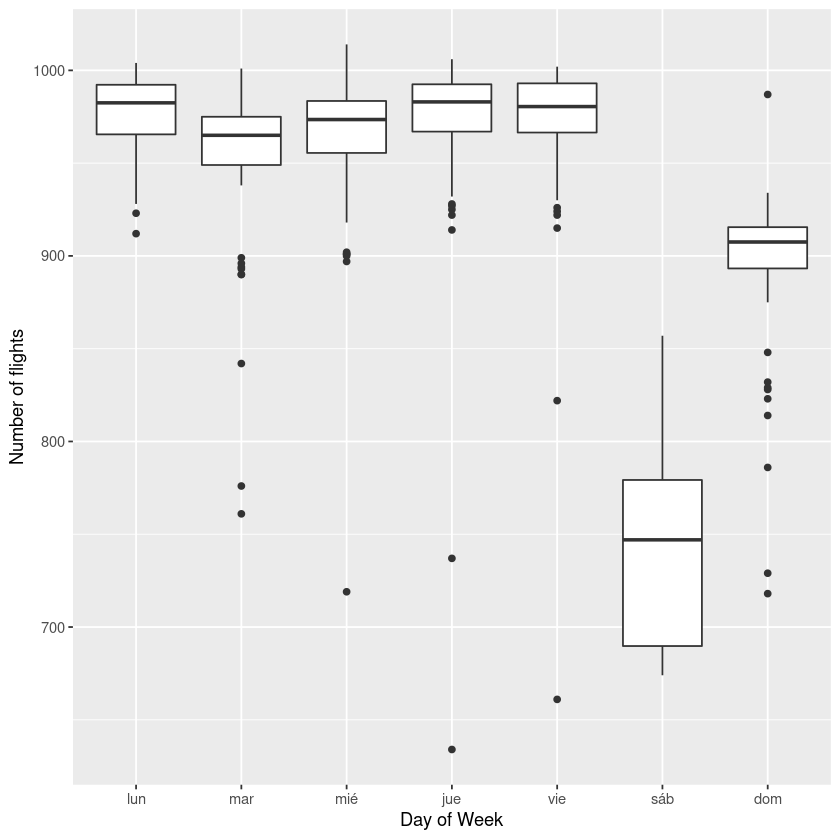

In [119]:
daily <- daily %>%
  mutate(wday = wday(date, label = TRUE))
ggplot(daily, aes(monday_first(wday), n)) +
  geom_boxplot() +
  labs(x = "Day of Week", y = "Number of flights")